In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, prediction_error

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.model_selection import learning_curve

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import validation_curve

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv('data_elec_2.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               3395 non-null   object 
 1   PrimaryPropertyType        3395 non-null   object 
 2   Neighborhood               3395 non-null   object 
 3   LargestPropertyUseType     3395 non-null   object 
 4   NumberofBuildings          3395 non-null   float64
 5   NumberofFloors             3395 non-null   float64
 6   PropertyGFATotal           3395 non-null   float64
 7   PropertyGFAParking         3395 non-null   float64
 8   PropertyGFABuilding(s)     3395 non-null   float64
 9   LargestPropertyUseTypeGFA  3395 non-null   float64
 10  ENERGYSTARScore            3395 non-null   float64
 11  SiteEUI(kBtu/sf)           3395 non-null   float64
 12  SourceEUI(kBtu/sf)         3395 non-null   float64
 13  SiteEnergyUse(kBtu)        3395 non-null   float

In [3]:
# supprimer les variables qui conduisent la fuite d'information

data = data.drop(['NaturalGas(kBtu)','Electricity(kBtu)', 'SteamUse(kBtu)', 'SourceEUI(kBtu/sf)',
                 'SiteEUI(kBtu/sf)'], axis = 1)

In [4]:
data.describe()

NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count        3395.000000     3395.000000      3.395000e+03   
mean            1.107511        4.696024      9.506883e+04   
std             2.102399        5.478793      2.187380e+05   
min             0.000000        0.000000      1.128500e+04   
25%             1.000000        2.000000      2.846000e+04   
50%             1.000000        4.000000      4.418800e+04   
75%             1.000000        5.000000      9.110950e+04   
max           111.000000       99.000000      9.320156e+06   

       PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count         3395.000000            3.395000e+03               3.395000e+03   
mean          8241.203829            8.682762e+04               7.922921e+04   
std          33199.453042            2.074945e+05               2.011452e+05   
min              0.000000            3.636000e+03               5.656000e+03   
25%              0.000000            2.768500e+04               2.505400e+04   
50%              0.000000            4.321000e+04               3.986500e+04   
75%              0.000000            8.431250e+04               7.571750e+04   
max         512608.000000            9.320156e+06               9.320156e+06   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  TotalGHGEmissions  BuildingAge  \
count      3395.000000         3.395000e+03        3395.000000  3395.000000   
mean         67.676289         5.450231e+06         121.178895    47.575847   
std          26.954409         2.171134e+07         543.550414    33.184060   
min           1.000000         0.000000e+00           0.000000     1.000000   
25%          52.000000         9.274230e+05           9.485000    19.000000   
50%          75.000000         1.803753e+06          34.020000    42.000000   
75%          90.000000         4.229376e+06          94.265000    68.000000   
max         100.000000         8.739237e+08       16870.980000   116.000000   

       %GFABuilding  %GFAParking  
count   3395.000000  3395.000000  
mean       0.957692     0.042308  
std        0.115860     0.115860  
min        0.104977     0.000000  
25%        1.000000     0.000000  
50%        1.000000     0.000000  
75%        1.000000     0.000000  
max        1.000000     0.895023

In [5]:
# supprimer les données avec deux variables cibles = 0 

data = data[data['TotalGHGEmissions'] > 0]
data = data[data['SiteEnergyUse(kBtu)'] > 0]

# supprimer la donnée d'un bâtiment de type campus est très supérieur aux autres données.

data = data[data['SiteEnergyUse(kBtu)'] < 8*10**8]

data.shape

(3374, 16)

In [6]:


# des différents modèles de régression

rd_state = 42
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=rd_state)
lasso = Lasso(random_state=rd_state)
elas = ElasticNet(random_state=rd_state)
sgd = SGDRegressor()
knr = KNeighborsRegressor(n_neighbors = 1)
dt_reg =  DecisionTreeRegressor(random_state=rd_state)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=rd_state)
bagging = BaggingRegressor(random_state=rd_state)
gdboost = GradientBoostingRegressor(random_state=rd_state)
rdmforest = RandomForestRegressor(random_state=rd_state)

# la fonction pour montrer la performance des différents modèles avec leur paramètres par défaut


def evalution(X_train, y_train):

    model = [dummy_reg, elas, knr, dt_reg, svm_reg, bagging, gdboost, rdmforest]
    dict_model = {}
    

    for model in model:
        
        regressor = TransformedTargetRegressor(regressor=model,
                                               func=np.log,
                                               inverse_func=np.exp
                                              )
        preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
        pipeline = make_pipeline(preprocessor, 
                                 regressor)
        start_time = datetime.now()
        
        mae = cross_val_score(pipeline, X_train, y_train, cv = 4, scoring = 'neg_mean_absolute_error').mean().round(3)    
        rmse = cross_val_score(pipeline, X_train, y_train, cv = 4, scoring = 'neg_root_mean_squared_error').mean().round(3)
        r2 = cross_val_score(pipeline, X_train, y_train, cv = 4, scoring = 'r2').mean().round(3)
        mape = cross_val_score(pipeline, X_train, y_train, cv = 4, scoring = 'neg_mean_absolute_percentage_error').mean().round(3)
        
        end_time = datetime.now()
        execute_time = end_time - start_time
        
        dict_model[model] = (mae, rmse, r2,mape, execute_time)

    result = pd.DataFrame(dict_model, index= ["MAE", "RMSE", "R²",'MAPE', "execute time"])
    result.columns = ["Dummy Regressor", "ElasticNet",
                      "Kneighbors","DecisionTree", "SVM", "Bagging", 
                      "GradientBoosting", "Random Forest"]

    return result.T.sort_values('R²')

# la fonction montrer la performance d'un modèle avec les paramètres optimisées trouvée par GridSearchCV
# avec test set data

def score_final(model, X_test, y_test):
    
    start_time = datetime.now()
    dict_model = {}
    y_pred = model.predict(X_test)
        
    mae = mean_absolute_error(y_test, y_pred).round(3)
    mse = mean_squared_error(y_test, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    r2 = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    mape = mean_absolute_percentage_error(y_test, y_pred).round(3)
    
    end_time = datetime.now()
    execute_time = end_time - start_time
        
    dict_model[model] = (mae, rmse, r2, mape, execute_time)
    
    result = pd.DataFrame(dict_model, index= ["MAE", "RMSE", "R²", 'MAPE', "execute time"])
    result.columns = [str(model)]
    
    return result.T

# la fonction pour tracer learning curve

def ln_curve(model, X_train, y_train):
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                  cv=4, scoring='neg_mean_absolute_error',
                                                   train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(10, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.xticks(fontsize = 16)
    plt.xlabel('number of sample', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('neg_mean_absolute_error', rotation = 90, fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title (f'Learning cuvre of {str(model)}', fontsize = 24)

# la fonction pour montrer les meilleurs validation scores avec les paramètres optimisées trouvée par GridSearchCV

def model_scores(grid):
    df_results = pd.DataFrame.from_dict(grid.cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_mae = grid.best_score_
    best_rmse = np.mean(df_results[df_results.rank_test_neg_root_mean_squared_error == 1]['mean_test_neg_root_mean_squared_error'])
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_mape= np.mean(df_results[df_results.rank_test_neg_mean_absolute_percentage_error == 1]['mean_test_neg_mean_absolute_percentage_error'])
    best_params = grid.best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score RMSE: {}\nMeilleur Score R2 : {}\nMeilleur Score MAPE: {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}ms"\
         .format(round(best_mae,3), round(best_rmse, 3), round(best_r2,3), round(best_mape, 3), best_params, training_time))
    return df_results

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# la fonction pour afficher des valeurs prédites vs valeurs réélles

def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    plt.figure(figsize=(10,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles", fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize =14)
    plt.ylabel("Valeurs prédites", fontsize = 16)
    plt.title("Valeurs prédites VS valeurs réélles | {}".format(title), 
              fontdict=font_title, fontsize=18)
    plt.show()

#Fonction d'affichage des scores de GridSearch pour chacun des paramètres
def plot_search_results(grid, title): 
       
    ## Résultats de la GridSearch
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']

    ## Index de valeurs par hyper-paramètre
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    
    ## Plot des résultats
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Scores par paramètres pour la variable {}'.format(title), 
                 fontdict=font_title, fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="#2cb7b0")
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="#337da4")
        ax[i].set_xlabel(str(p[39:]).upper())

    plt.legend()
    plt.show()
    
    print("\nRappel des meilleurs paramètres :\n{}".format(grid.best_params_))

# A. Prédiction de l'utilisation d'énergie

# A.1 Utilisation des differents models avec leur paramètres par défaut

In [7]:
# Séparation des variables catégorielles et numériques

cat_feature = []
for col in data.select_dtypes(['object', 'category']):    
    cat_feature.append(col)

    
num_feature = []
for col in data.select_dtypes(['float64', 'int64']):
    num_feature.append(col)
    
num_feature.remove('ENERGYSTARScore')
num_feature.remove('TotalGHGEmissions')
num_feature.remove('SiteEnergyUse(kBtu)')

# Création d'un pipeline de transformation


encoder_OH = OneHotEncoder()

encoder_OE = OrdinalEncoder()

encoder_TE = TargetEncoder()

scaler_std = StandardScaler()

scaler_minmax = MinMaxScaler()

scaler_robust = RobustScaler()

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

In [8]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"

rd_state = 42
train_set, test_set = train_test_split(data, 
                                       test_size=0.2,
                                       random_state= rd_state, stratify = data['PrimaryPropertyType']
                                      )

y_train = train_set[['SiteEnergyUse(kBtu)']]
y_test = test_set[['SiteEnergyUse(kBtu)']]
X_train = train_set.drop(['ENERGYSTARScore','SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
X_test = test_set.drop(['ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)

In [9]:
from datetime import datetime

start_time = datetime.now()

resume = evalution(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

resume

Duration: 0:00:46.630383


MAE           RMSE      R²   MAPE  \
ElasticNet       -11358640.793 -125774469.327 -82.024 -1.787   
DecisionTree       -3054249.15  -15211259.577  -0.168 -0.969   
Dummy Regressor   -4240583.235  -16433451.395  -0.051  -1.08   
SVM               -3568267.163  -14476446.032   0.196 -1.171   
Kneighbors        -3384730.246  -13619712.824   0.248  -1.03   
Bagging           -2259294.003  -10554055.403   0.585 -0.632   
Random Forest       -2127061.0  -10175853.312   0.615 -0.582   
GradientBoosting  -2010782.814   -9598198.365   0.655 -0.544   

                           execute time  
ElasticNet       0 days 00:00:02.226647  
DecisionTree     0 days 00:00:01.579859  
Dummy Regressor  0 days 00:00:01.213759  
SVM              0 days 00:00:09.960769  
Kneighbors       0 days 00:00:01.302891  
Bagging          0 days 00:00:02.812359  
Random Forest    0 days 00:00:21.355051  
GradientBoosting 0 days 00:00:06.175739

# A.2 Essaies avec feature engineering

In [10]:
regressor = TransformedTargetRegressor(regressor=gdboost,
                                       func=np.log,
                                       inverse_func=np.exp)
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

start_time = datetime.now()

feature_engineering = make_pipeline(preprocessor, 
                                    PolynomialFeatures(include_bias=False),
                                    SelectKBest(f_regression), 
                                    PCA(),
                                    regressor)


params = {'polynomialfeatures__degree': [1, 2],
         'selectkbest__k': [10, 4, 7, 13],
         'pca__n_components': [0.97, 0.9, 0.8, 0.6]
          #'transformedtargetregressor__regressor__min_samples_split': [2, 5, 10], 
          #'transformedtargetregressor__regressor__max_features' : [0.8, 1.0, 0.9],
          #'transformedtargetregressor__regressor__n_estimators' : [10, 100, 500],
          #'transformedtargetregressor__regressor__min_samples_leaf' : [2, 3, 5]
        }

grid_feature = GridSearchCV(feature_engineering, param_grid =params, 
                            scoring = ('neg_mean_absolute_error',
                                       'neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_percentage_error'),
                            refit='neg_mean_absolute_error',
                            cv = 4, n_jobs=-1)
grid_feature.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

Duration: 0:00:13.124016


In [11]:
feature_result = model_scores(grid_feature)

Meilleur score MAE : -2544323.176
Meilleur Score RMSE: -11399934.379
Meilleur Score R2 : 0.51
Meilleur Score MAPE: -0.714
Meilleurs paramètres : {'pca__n_components': 0.97, 'polynomialfeatures__degree': 2, 'selectkbest__k': 4}
Temps moyen d'entrainement : 1261.71ms


# A.3 Optimisation de model ElasticNet

In [12]:
start_time = datetime.now()

params = {"transformedtargetregressor__regressor__max_iter": [10, 100, 1000],
          "transformedtargetregressor__regressor__alpha": np.logspace(-4, 0, num=5),
          "transformedtargetregressor__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

regressor = TransformedTargetRegressor(regressor=ElasticNet(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_elas = make_pipeline(preprocessor, regressor)

grid_elas = GridSearchCV(pre_elas, param_grid =params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_elas.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.9736392809937, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 667.802868273065, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.8802996030349, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/s

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.8046509627951, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 628.4681796127672, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.114412596621, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.0767264679115, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616.1422615320454, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 667.9026236459298, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626.5040055720152, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0601554773913, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 639.1074408034708, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635.0924908505554, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.7062144093496, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.9058538946948, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.9690155137931, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.4693882656338, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.7374087860505, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.8631052414725, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.0170560639015, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.6460806047004, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.3828012727952, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.0384193347437, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 664.2406139945488, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.178280103657, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8456645554597, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 637.0788376154763, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/s

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.8236169033954, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.5685904978952, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635.7890686340411, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.4213165065623, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.1889672913546, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.8862590281367, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.97129953519277, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.353365640996344, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 683.8002080171034, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.7652503704867, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.3171186346125, tolerance: 0.2710954695807748
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.3896855494238, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614.3270832360744, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.7804790897228, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.3975250072436, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 671.4141337429172, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.3597175630301, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.494289829188, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/s

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716.0174935302431, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 789.7364728616278, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 755.3593411079339, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.6951976943953, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 756.4726186492194, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 724.5243564972542, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 912.15521806221, tolerance: 0.2594484405808756
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.0290085826515, tolerance: 0.272892176388707
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 946.1602900044679, tolerance: 0.2749859978429227
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sk

Duration: 0:00:21.875264


In [13]:
elas_result =model_scores(grid_elas)

Meilleur score MAE : -10879373.515
Meilleur Score RMSE: -123799337.465
Meilleur Score R2 : -72.95
Meilleur Score MAPE: -1.027
Meilleurs paramètres : {'transformedtargetregressor__regressor__alpha': 1.0, 'transformedtargetregressor__regressor__l1_ratio': 0.4, 'transformedtargetregressor__regressor__max_iter': 100}
Temps moyen d'entrainement : 279.2ms


# A.4 Optimisation de model KNeighborsRegression

In [14]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_neighbors': [int(x) for x in np.linspace(1, 100, 100)]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

regressor = TransformedTargetRegressor(regressor=KNeighborsRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_knr = make_pipeline(preprocessor, regressor)

grid_knr = GridSearchCV(pre_knr, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)



grid_knr.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:19.502715


In [15]:
knr_result =model_scores(grid_knr)

Meilleur score MAE : -2951525.96
Meilleur Score RMSE: -12826249.75
Meilleur Score R2 : 0.363
Meilleur Score MAPE: -0.838
Meilleurs paramètres : {'transformedtargetregressor__regressor__n_neighbors': 3}
Temps moyen d'entrainement : 368.74ms


# A.5 Optimisation de model RandomForestRegressor 

In [16]:
start_time = datetime.now()


params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : [0.97, 1.0, 0.9],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,3,4],
           "transformedtargetregressor__regressor__min_samples_split" : [2,3,4],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_forest = make_pipeline(preprocessor, regressor)

grid_forest = GridSearchCV(pre_forest, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_forest.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:40.216963


In [17]:
forest_result = model_scores(grid_forest)

Meilleur score MAE : -2155377.989
Meilleur Score RMSE: -10044580.51
Meilleur Score R2 : 0.624
Meilleur Score MAPE: -0.57
Meilleurs paramètres : {'transformedtargetregressor__regressor__bootstrap': True, 'transformedtargetregressor__regressor__max_features': 0.9, 'transformedtargetregressor__regressor__min_samples_leaf': 2, 'transformedtargetregressor__regressor__min_samples_split': 4, 'transformedtargetregressor__regressor__n_estimators': 10}
Temps moyen d'entrainement : 8591.78ms


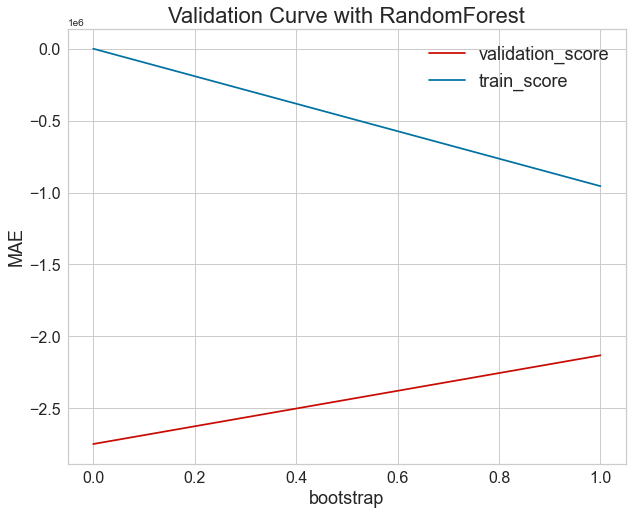

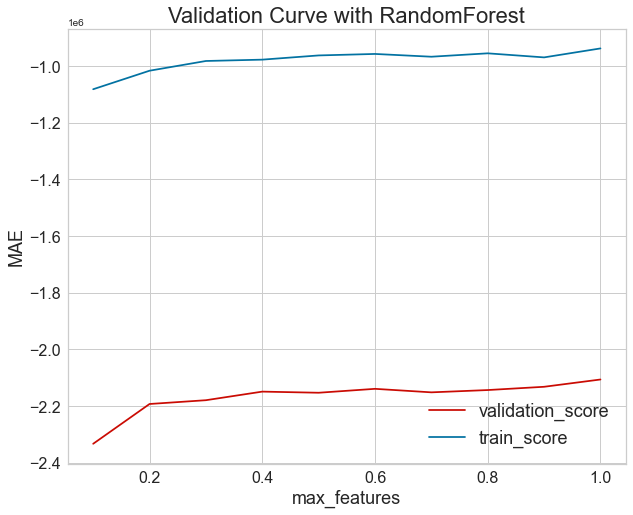

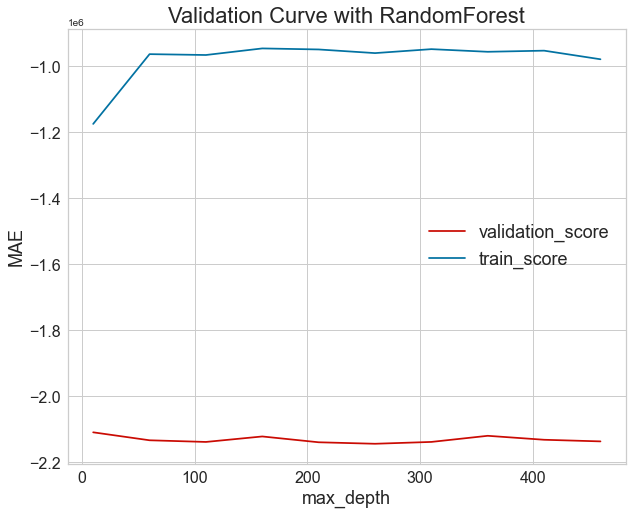

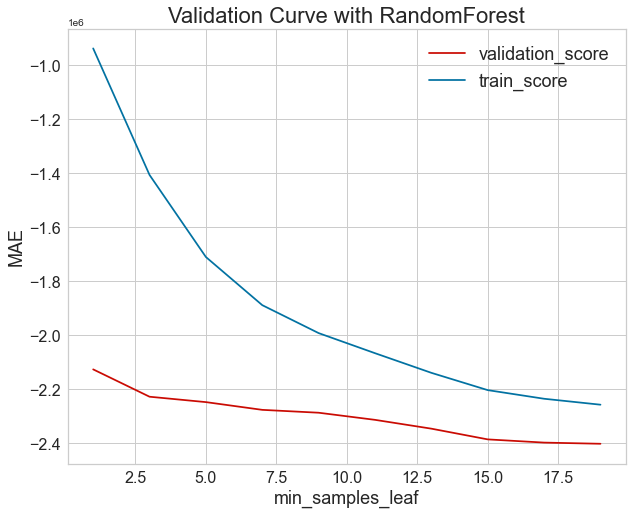

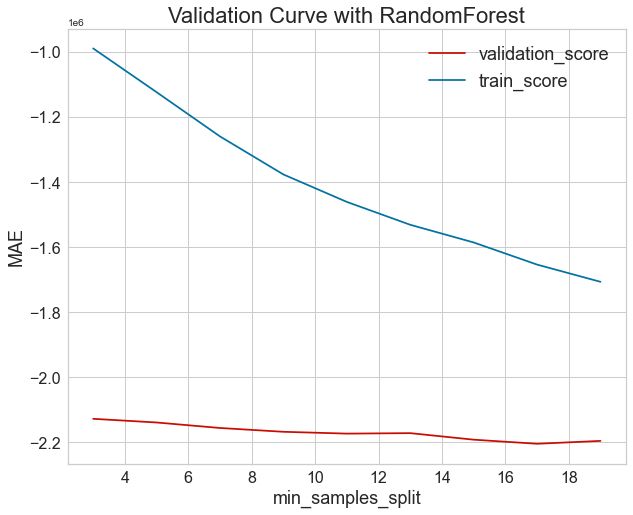

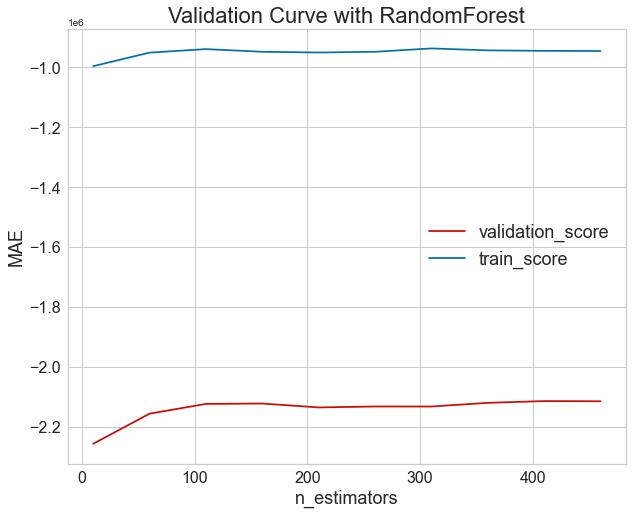

In [18]:
params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : np.linspace(0.1, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth": np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_forest, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with RandomForest', fontsize = 22)

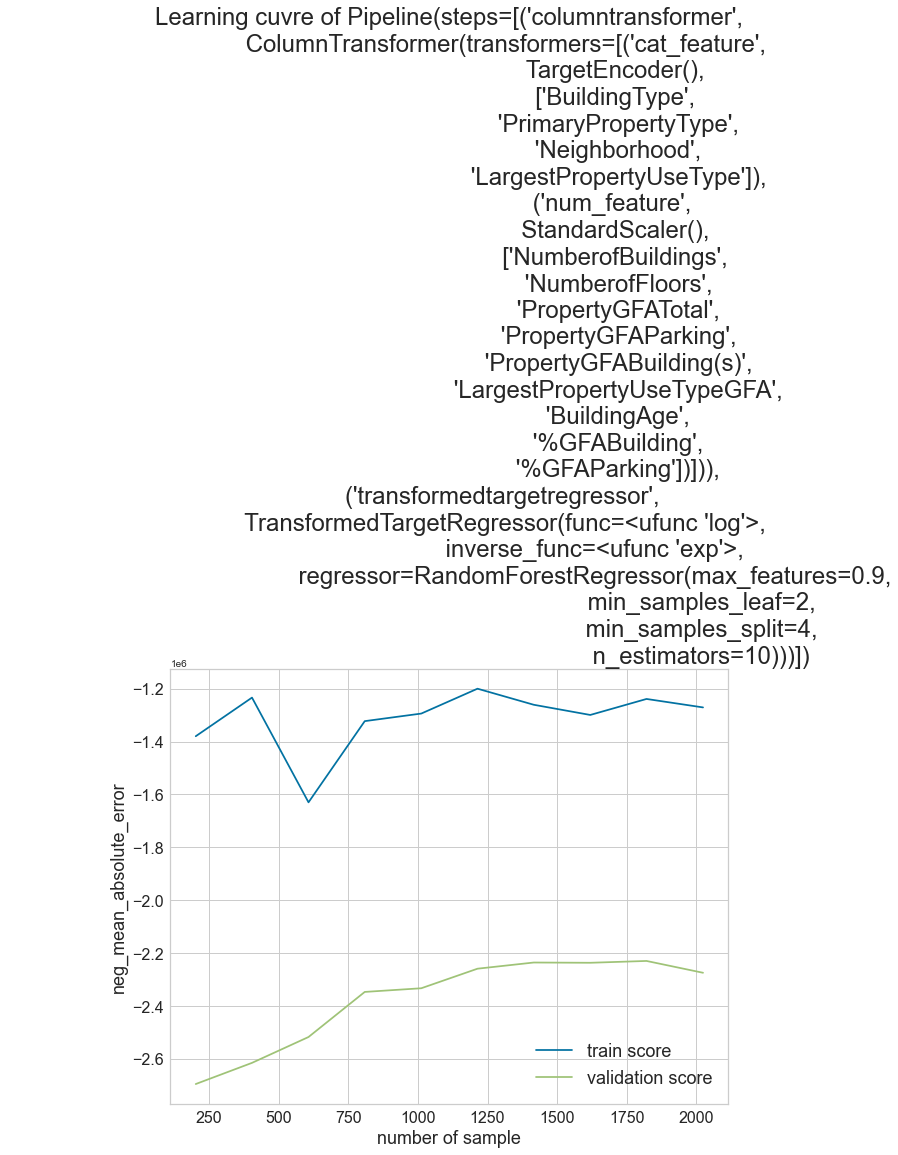

In [19]:
ln_curve(grid_forest.best_estimator_, X_train, y_train)

# A.6 Optimisation de model GradientBoosting

In [20]:
start_time = datetime.now()

params = {"transformedtargetregressor__regressor__learning_rate" : [0.1, 0.3, 0.7],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,5, 10],
           "transformedtargetregressor__regressor__min_samples_split" : [2, 5, 10],
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": [0.0,0.1, 0.2],
          "transformedtargetregressor__regressor__max_depth" : [2 ,5, 10],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_gdb = make_pipeline(preprocessor, regressor)

grid_gdb = GridSearchCV(pre_gdb, param_grid = params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_gdb.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:08:16.809850


In [21]:
gdb_result = model_scores(grid_gdb)

Meilleur score MAE : -1988231.45
Meilleur Score RMSE: -9398529.708
Meilleur Score R2 : 0.671
Meilleur Score MAPE: -0.546
Meilleurs paramètres : {'transformedtargetregressor__regressor__learning_rate': 0.3, 'transformedtargetregressor__regressor__max_depth': 2, 'transformedtargetregressor__regressor__min_samples_leaf': 10, 'transformedtargetregressor__regressor__min_samples_split': 2, 'transformedtargetregressor__regressor__min_weight_fraction_leaf': 0.0, 'transformedtargetregressor__regressor__n_estimators': 100}
Temps moyen d'entrainement : 3420.41ms


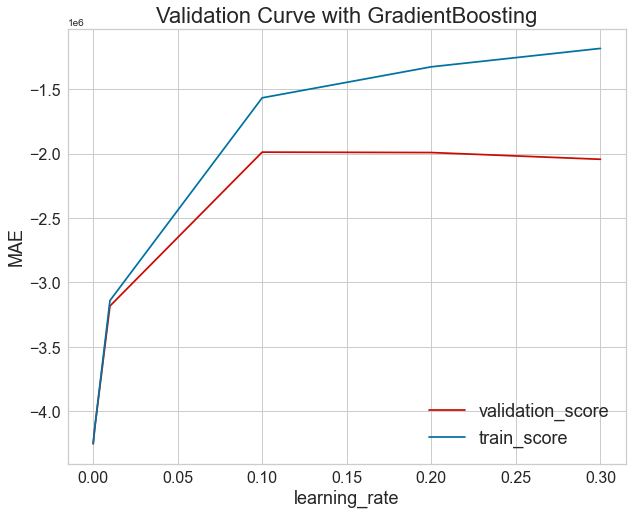

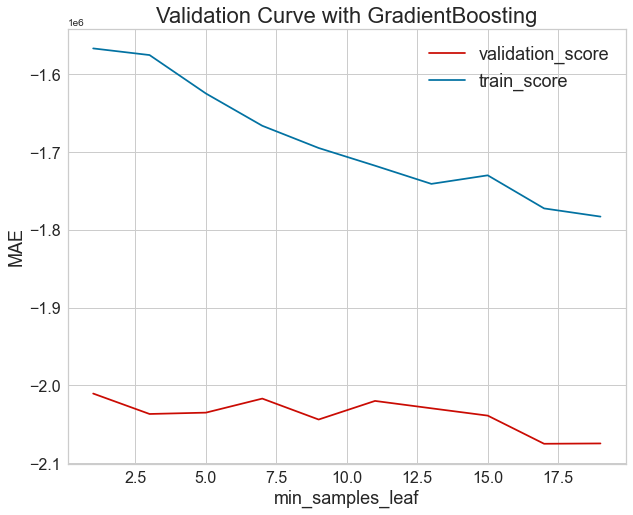

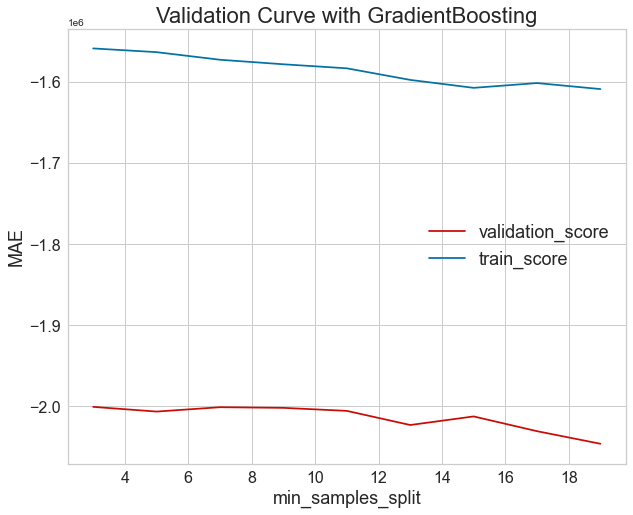

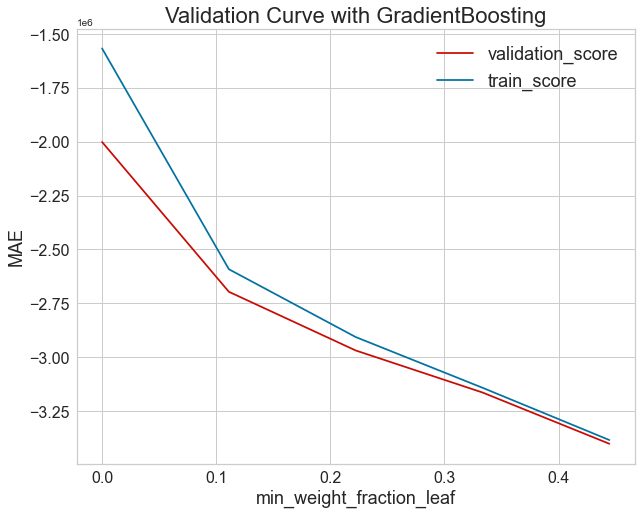

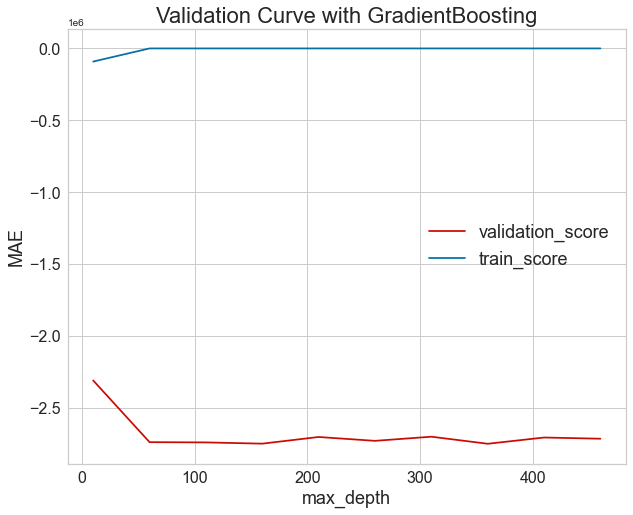

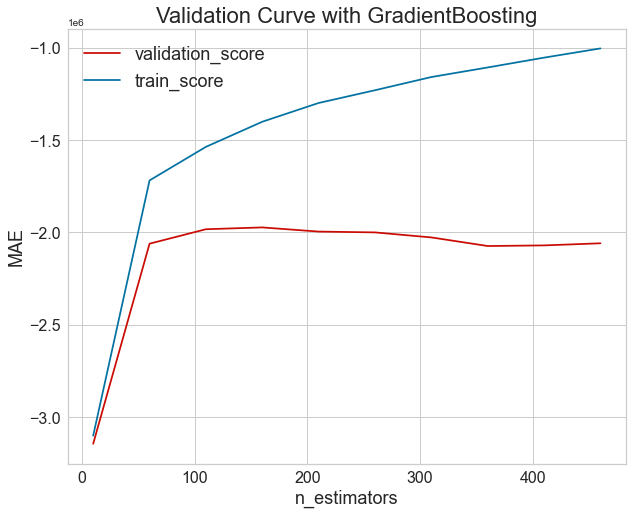

In [22]:

params = {"transformedtargetregressor__regressor__learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": np.linspace(0.0, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth" : np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }


for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_gdb, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with GradientBoosting', fontsize = 22)

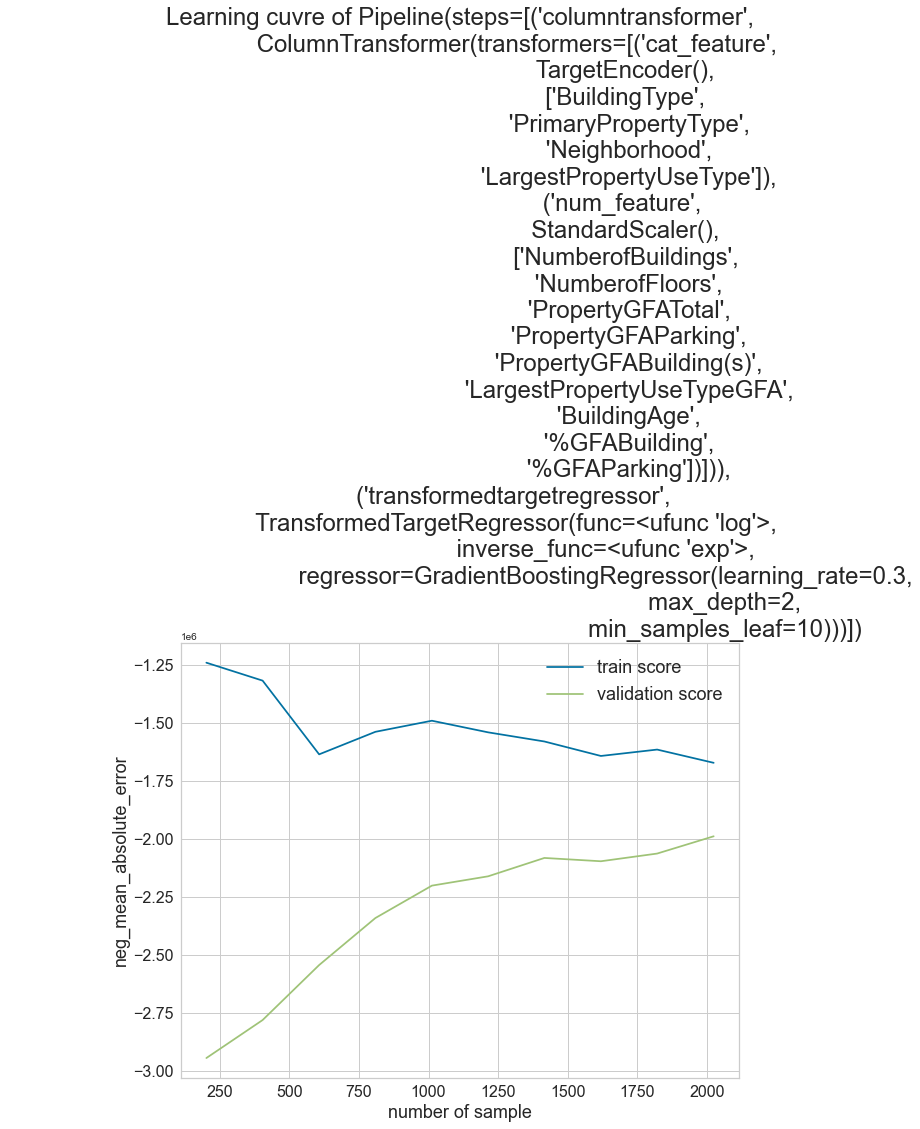

In [23]:
ln_curve(grid_gdb.best_estimator_, X_train, y_train)

# A.7 Optimisation de model Bagging

In [62]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_estimators': [10, 50, 100, 200],
          'transformedtargetregressor__regressor__max_samples': [1.0, 0.8, 0.5, 0.3],
          'transformedtargetregressor__regressor__max_features': [1.0, 0.8, 0.5, 0.3]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

regressor = TransformedTargetRegressor(regressor=BaggingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_bag = make_pipeline(preprocessor, regressor)

grid_bag = GridSearchCV(pre_bag, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_bag.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:51.100441


In [63]:
bag_result =model_scores(grid_bag)

Meilleur score MAE : -2124404.35
Meilleur Score RMSE: -10110426.638
Meilleur Score R2 : 0.62
Meilleur Score MAPE: -0.565
Meilleurs paramètres : {'transformedtargetregressor__regressor__max_features': 1.0, 'transformedtargetregressor__regressor__max_samples': 1.0, 'transformedtargetregressor__regressor__n_estimators': 200}
Temps moyen d'entrainement : 3211.8ms


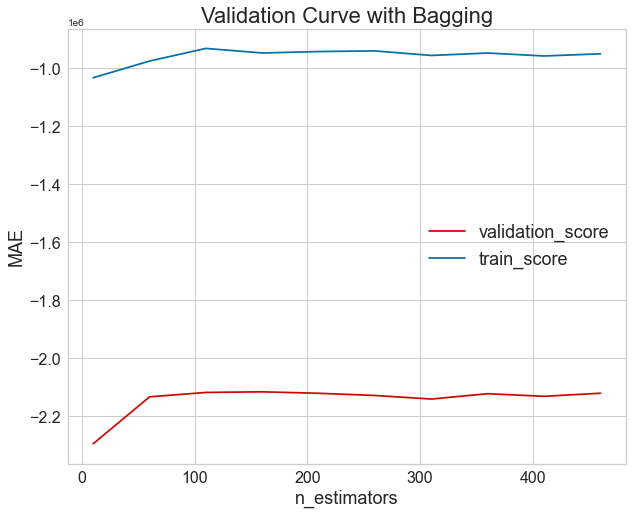

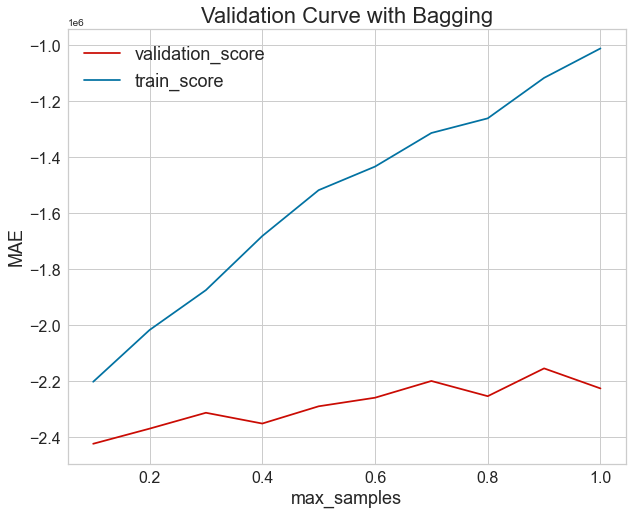

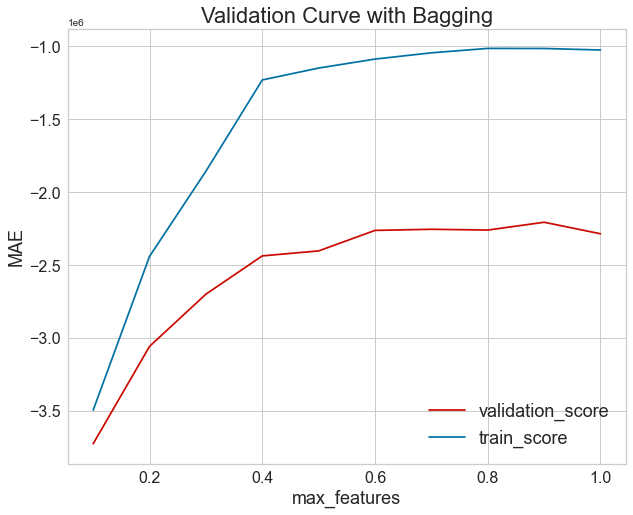

In [64]:
params = {'transformedtargetregressor__regressor__n_estimators': np.arange(10, 500, 50),
          'transformedtargetregressor__regressor__max_samples': np.linspace(0.1, 1.0, 10),
          'transformedtargetregressor__regressor__max_features': np.linspace(0.1, 1.0, 10)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_bag, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with Bagging', fontsize = 22)

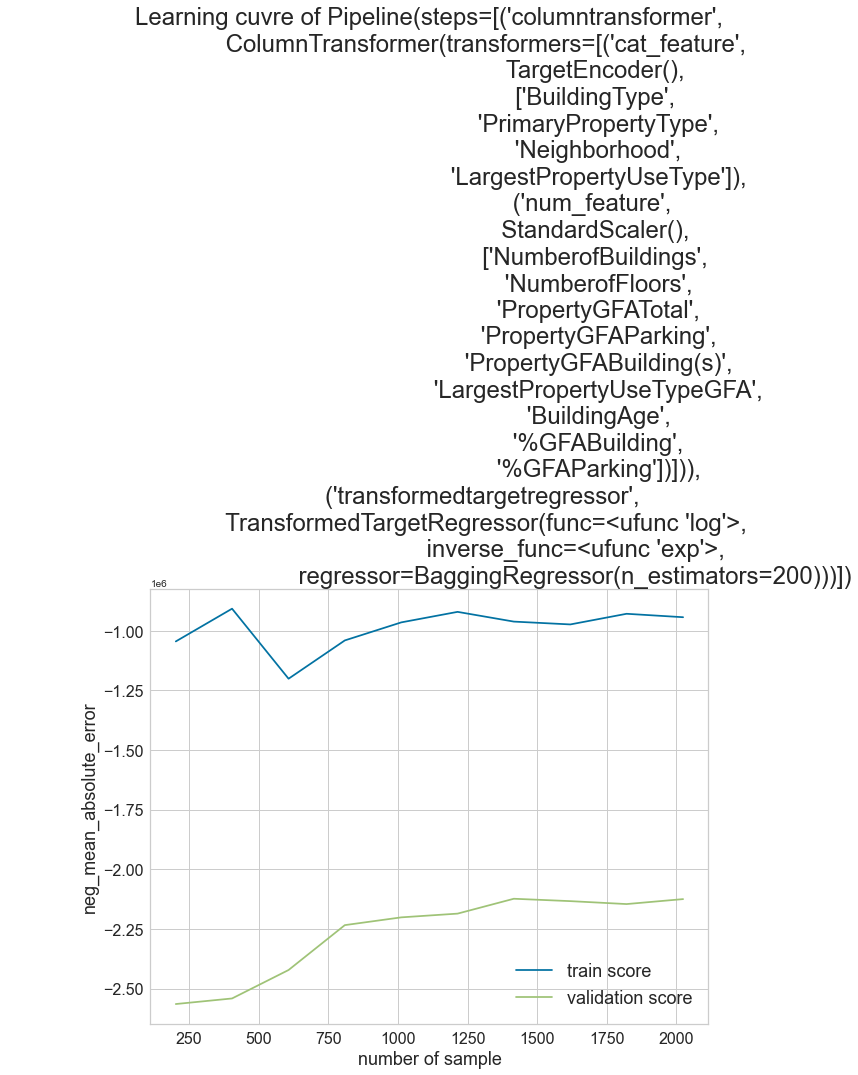

In [65]:
ln_curve(grid_bag.best_estimator_, X_train, y_train)

# A.8 Comparer les modèles

In [66]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

model_compare = pd.concat([pd.DataFrame(elas_result[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(knr_result[metrics].mean(), columns=['KNeighbor']),
           pd.DataFrame(bag_result[metrics].mean(), columns=['Bagging']),
           pd.DataFrame(forest_result[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(gdb_result[metrics].mean(), columns=['GradientBoosting'])
          ], axis=1)
final_compare = pd.DataFrame(columns=metrics, 
                                     index=['ElasticNet','KNeighbors',
                                            'Bagging','RandomForest',
                                            'GradientBoosting'])
for m in metrics:
    final_compare[m] = model_compare.loc[m]
    

final_compare = model_compare.T.rename({'mean_fit_time' : 'fit_time', 
                                        'mean_score_time': 'score_time',
                                        'mean_test_neg_mean_absolute_error': 'validation_MAE',
                                        'mean_train_neg_mean_absolute_error': 'train_MAE'},
                                      axis = 1)
final_compare.sort_values('validation_MAE')

fit_time  score_time  validation_MAE     train_MAE
ElasticNet        0.103446    0.027999   -5.596809e+07 -3.631478e+07
KNeighbor         0.136623    0.073230   -3.474200e+06 -3.332615e+06
GradientBoosting  1.267286    0.034182   -2.689721e+06 -2.161089e+06
Bagging           1.189996    0.077529   -2.372988e+06 -1.605303e+06
RandomForest      3.183319    0.092304   -2.357318e+06 -1.256674e+06

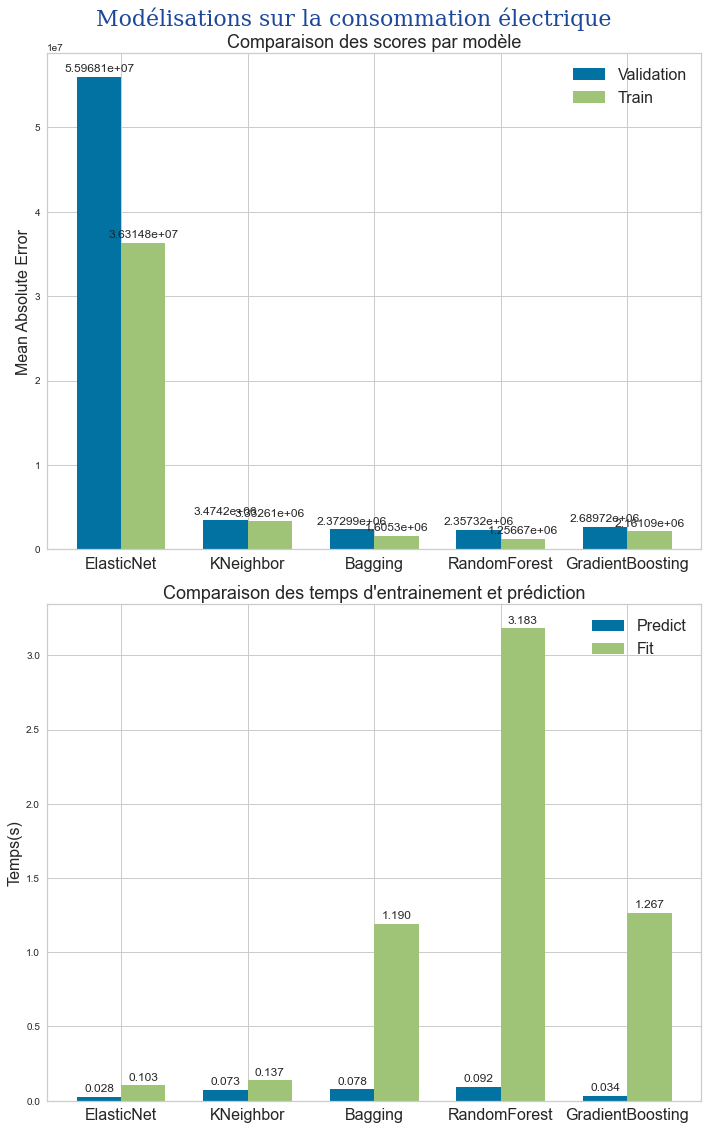

In [67]:
x = np.arange(len(final_compare.index))
width = 0.35

fig, ax = plt.subplots(2,1,figsize=(10,16), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*final_compare['validation_MAE'], width, label='Validation')
scores2 = ax[0].bar(x + width/2, -1*final_compare['train_MAE'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error', fontsize = 16)
ax[0].set_title('Comparaison des scores par modèle', fontsize = 18)
ax[0].set_xticks(x)
ax[0].set_xticklabels(final_compare.index, fontsize = 16)
ax[0].legend(fontsize = 16)
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, final_compare['score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, final_compare['fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)', fontsize = 16)
ax[1].set_title("Comparaison des temps d'entrainement et prédiction", fontsize = 18)
ax[1].set_xticks(x)
ax[1].set_xticklabels(final_compare.index, fontsize = 16)
ax[1].legend(fontsize = 16)
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la consommation électrique", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

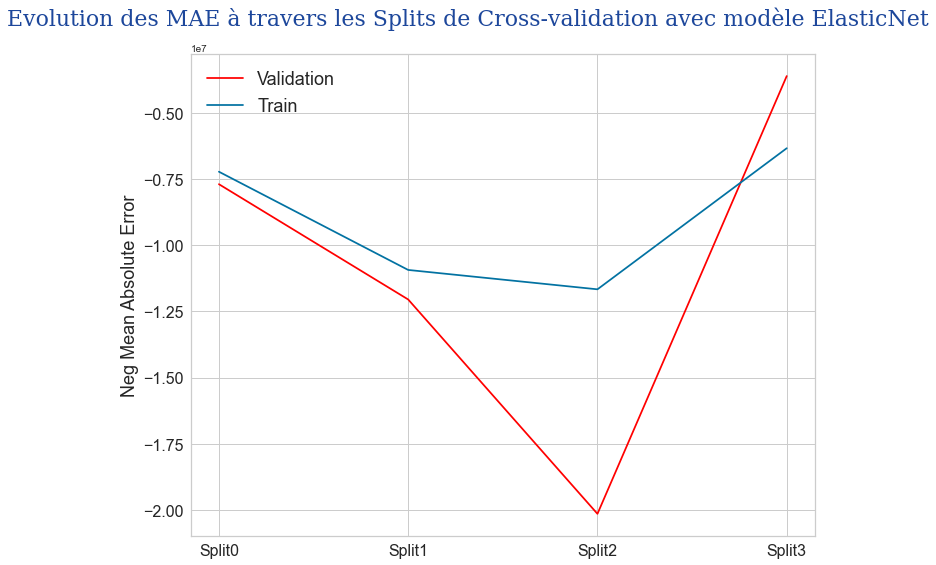

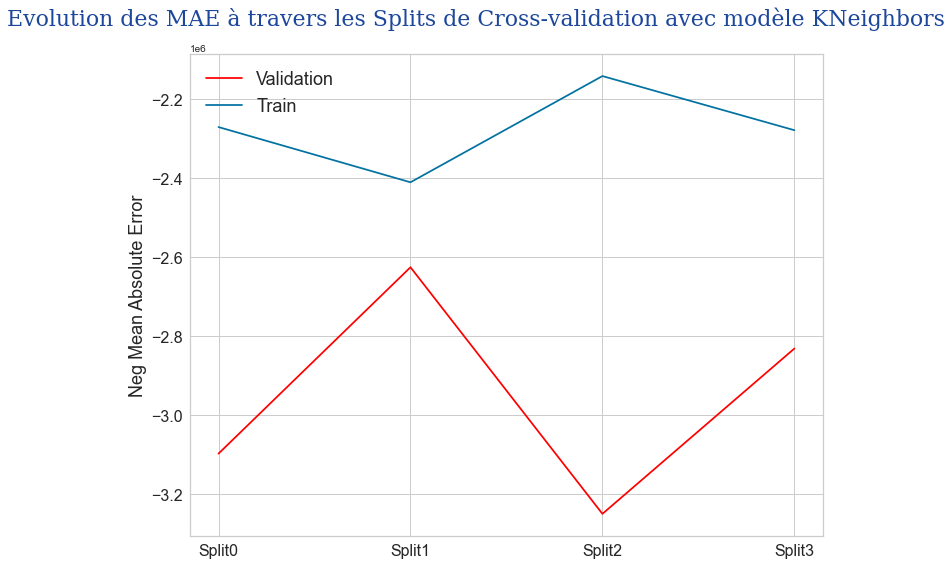

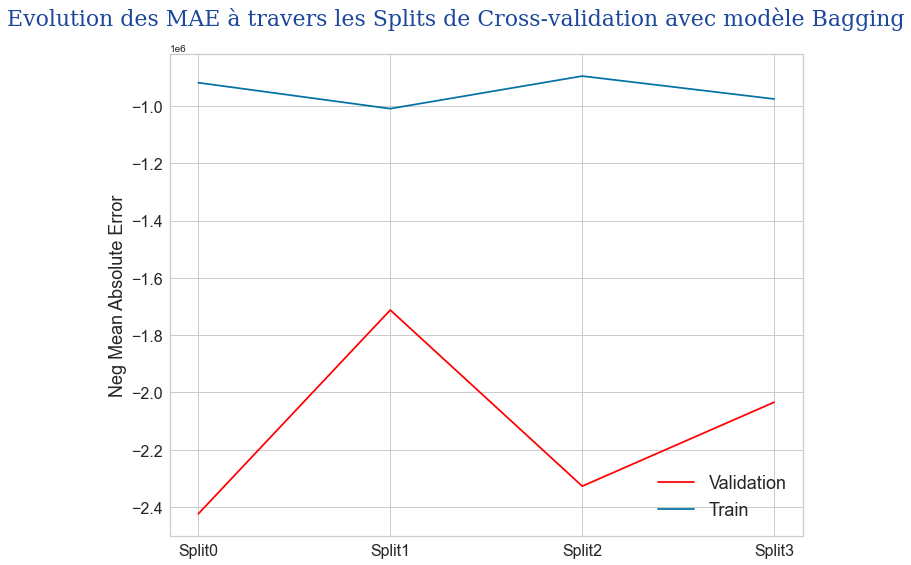

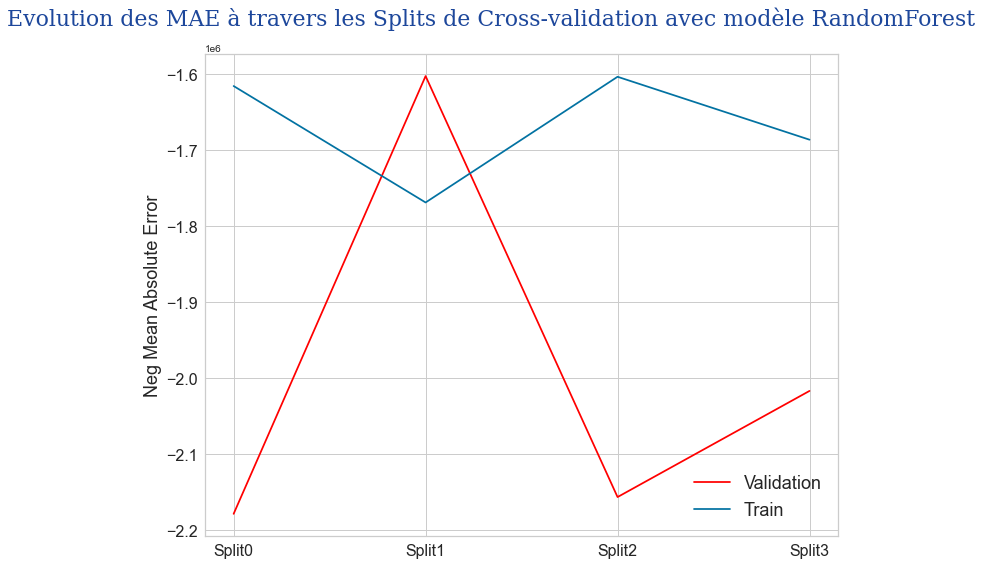

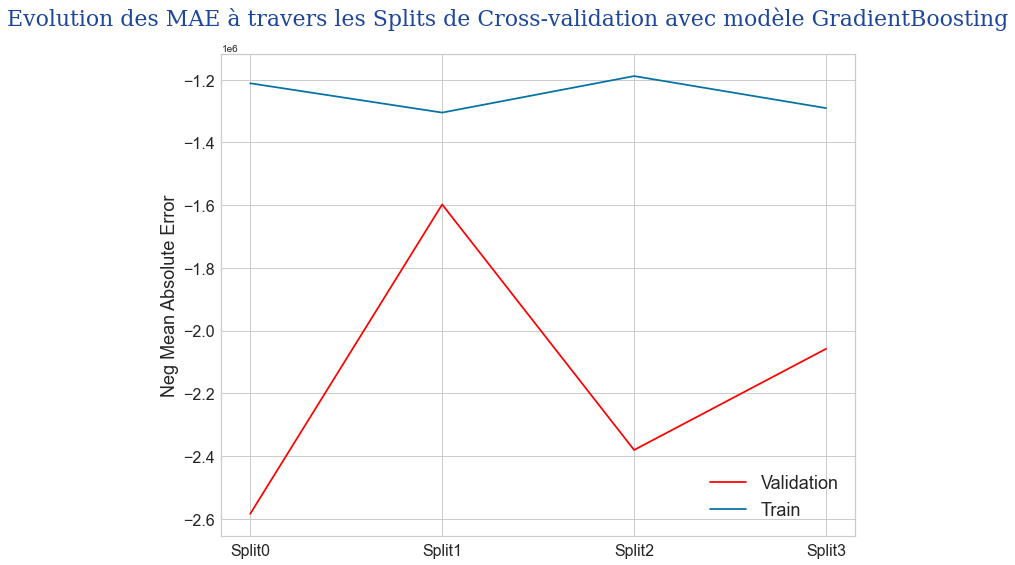

In [68]:
model = ['ElasticNet','KNeighbors','Bagging','RandomForest','GradientBoosting']
i = 0
for result in [elas_result, knr_result, bag_result, gdb_result, forest_result]:

    validation_results = result[['split0_test_neg_mean_absolute_error',
                    'split1_test_neg_mean_absolute_error',
                    'split2_test_neg_mean_absolute_error',
                    'split3_test_neg_mean_absolute_error',
                    #'split4_test_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T
    train_results = result[['split0_train_neg_mean_absolute_error',
                    'split1_train_neg_mean_absolute_error',
                    'split2_train_neg_mean_absolute_error',
                    'split3_train_neg_mean_absolute_error',
                    #'split4_train_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T


    x = np.arange(0,4,1)
    fig, ax = plt.subplots(figsize=(10,8), sharey=False, sharex=False)
    ax.plot(range(0,4), validation_results.iloc[:, 0], c = 'red', label = 'Validation')
    ax.set_xticks(x)
    plt.yticks(fontsize = 16)
    ax.set_xticklabels(["Split"+str(n) for n in range(0,4)], fontsize = 16)
    ax.set_ylabel('Neg Mean Absolute Error', fontsize = 18)

    ax.plot(range(0,4), train_results.iloc[:, 0], color='b', label = 'Train')
    
    ax.legend(fontsize = 18)


    plt.suptitle(f"Evolution des MAE à travers les Splits de Cross-validation avec modèle {model[i]}", fontdict=font_title, fontsize=22)
    i= i +1
    fig.tight_layout()

    plt.show()

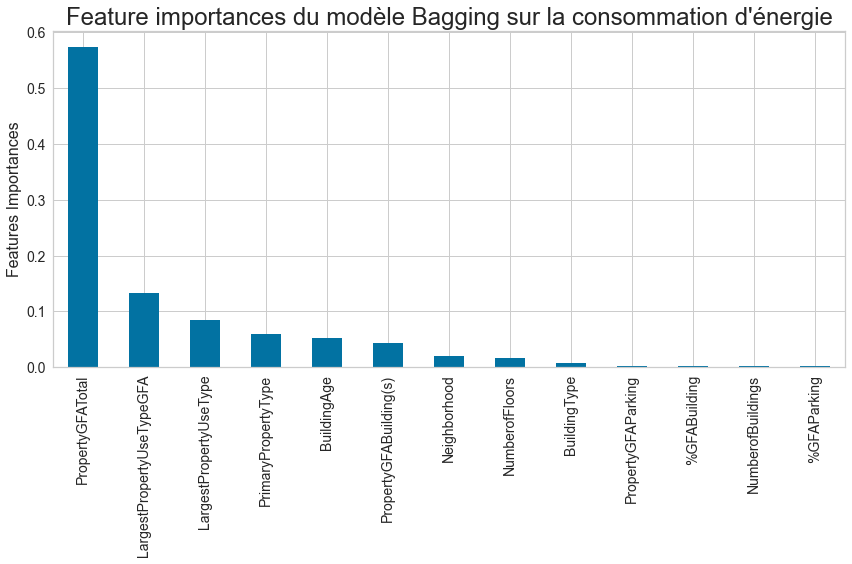

In [69]:

feature_importance = np.mean([tree.feature_importances_ for tree in\
                              grid_bag.best_estimator_.named_steps['transformedtargetregressor']\
                              .regressor_.estimators_], axis=0)
feature_names = cat_feature + num_feature


df_feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar()
ax.set_title("Feature importances du modèle Bagging sur la consommation d'énergie",
             fontsize = 24)
ax.set_ylabel("Features Importances", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks( fontsize = 14)
fig.tight_layout()

# A.9 Prédire avec le modèle choisi (Bagging)

In [70]:
score_final(grid_bag, X_test, y_test)

MAE         RMSE  \
GridSearchCV(cv=4,\n             estimator=Pipe...  1941594.03  5543011.775   

                                                       R²  MAPE  \
GridSearchCV(cv=4,\n             estimator=Pipe...  0.802  0.57   

                                                             execute time  
GridSearchCV(cv=4,\n             estimator=Pipe... 0 days 00:00:00.061368

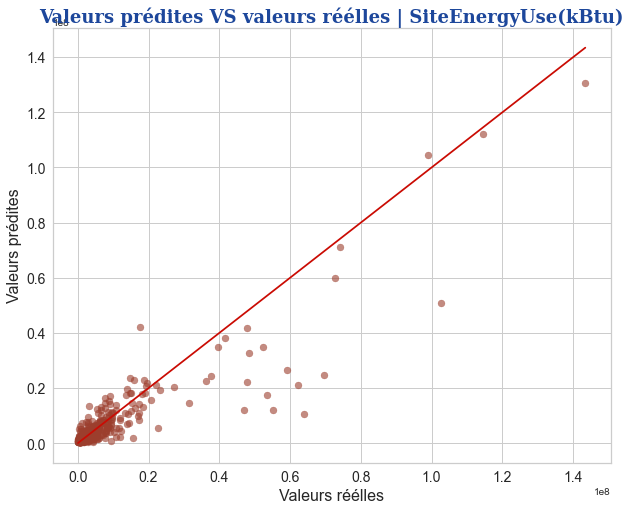

In [72]:
plot_pred_true(y_test,grid_bag.best_estimator_.predict(X_test), color="#9C3E2D", title="SiteEnergyUse(kBtu)")

# A.10 Feature importante avec model Bagging 

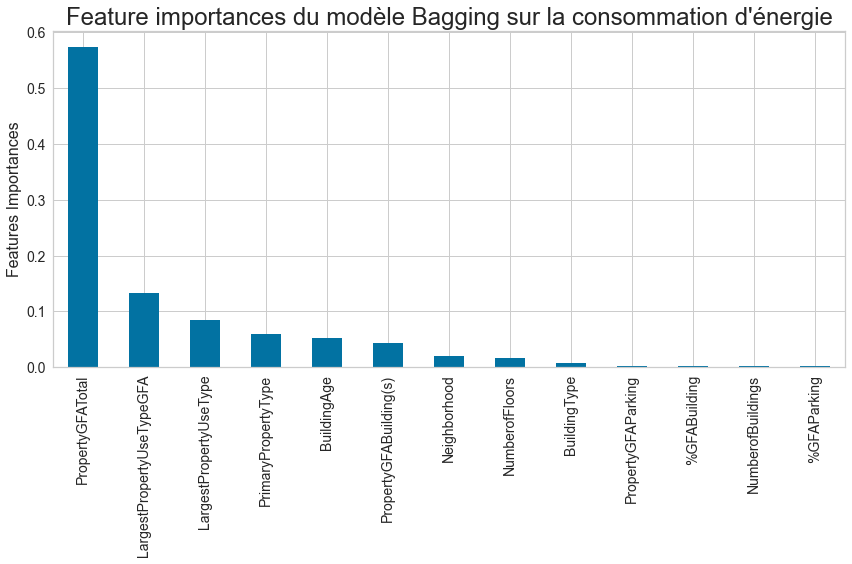

In [73]:

feature_importance = np.mean([tree.feature_importances_ for tree in\
                              grid_bag.best_estimator_.named_steps['transformedtargetregressor']\
                              .regressor_.estimators_], axis=0)
feature_names = cat_feature + num_feature


df_feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar()
ax.set_title("Feature importances du modèle Bagging sur la consommation d'énergie",
             fontsize = 24)
ax.set_ylabel("Features Importances", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks( fontsize = 14)
fig.tight_layout()

# B. Prédiction de l'émission de CO2

# B. 1 Sans EnergyStarScore

## B.1.1 Differents models avec leur parametres par défaut

In [74]:
cat_feature = []
for col in data.select_dtypes(['object', 'category']):    
    cat_feature.append(col)

    
num_feature = []
for col in data.select_dtypes(['float64', 'int64']):
    num_feature.append(col)
    
num_feature.remove('ENERGYSTARScore')
num_feature.remove('TotalGHGEmissions')
num_feature.remove('SiteEnergyUse(kBtu)')


preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

In [75]:
train_set, test_set = train_test_split(data, 
                                       test_size=0.2,
                                       random_state=rd_state, stratify = data['PrimaryPropertyType'])

y_train = train_set[['TotalGHGEmissions']]
y_test = test_set[['TotalGHGEmissions']]
X_train = train_set.drop(['ENERGYSTARScore','SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
X_test = test_set.drop(['ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)


In [76]:
from datetime import datetime

start_time = datetime.now()

resume = evalution(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

resume

Duration: 0:00:39.221917


MAE      RMSE      R²   MAPE           execute time
ElasticNet       -233.461 -2344.215 -18.891 -3.941 0 days 00:00:01.410335
DecisionTree      -96.504  -480.792  -0.541 -2.265 0 days 00:00:01.363794
Dummy Regressor  -104.935  -517.117  -0.033 -2.599 0 days 00:00:01.125564
SVM               -94.083  -475.254   0.133 -2.489 0 days 00:00:08.000202
Kneighbors        -97.449  -429.739   0.226 -2.284 0 days 00:00:01.264241
Bagging           -72.525  -359.838   0.458 -1.396 0 days 00:00:02.673344
Random Forest     -70.277  -354.041   0.509 -1.351 0 days 00:00:17.269776
GradientBoosting  -69.142  -341.899   0.556 -1.298 0 days 00:00:06.111563

## B.1.2 Essaies avec feature engineering

In [77]:
regressor = TransformedTargetRegressor(regressor=gdboost,
                                       func=np.log,
                                       inverse_func=np.exp)
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
start_time = datetime.now()

feature_engineering = make_pipeline(preprocessor, 
                                    PolynomialFeatures(include_bias=False),
                                    SelectKBest(f_regression), 
                                    PCA(),
                                    regressor)


params = {'polynomialfeatures__degree': [1, 2],
         'selectkbest__k': [10, 4, 7, 13],
         'pca__n_components': [0.97, 0.9, 0.8, 0.6]
          #'transformedtargetregressor__regressor__min_samples_split': [2, 5, 10], 
          #'transformedtargetregressor__regressor__max_features' : [0.8, 1.0, 0.9],
          #'transformedtargetregressor__regressor__n_estimators' : [10, 100, 500],
          #'transformedtargetregressor__regressor__min_samples_leaf' : [2, 3, 5]
        }

grid_feature = GridSearchCV(feature_engineering, param_grid =params, 
                            scoring = ('neg_mean_absolute_error',
                                       'neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_percentage_error'),
                            refit='neg_mean_absolute_error',
                            cv = 4, n_jobs=-1)
grid_feature.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

Duration: 0:00:10.503005


In [78]:
feature_result = model_scores(grid_feature)

Meilleur score MAE : -77.524
Meilleur Score RMSE: -349.553
Meilleur Score R2 : 0.521
Meilleur Score MAPE: -1.586
Meilleurs paramètres : {'pca__n_components': 0.97, 'polynomialfeatures__degree': 2, 'selectkbest__k': 4}
Temps moyen d'entrainement : 1061.59ms


## B.1.3 Optimisation de model ElasticNet

In [79]:
start_time = datetime.now()

params = {"transformedtargetregressor__regressor__max_iter": [10, 100, 1000],
          "transformedtargetregressor__regressor__alpha": np.arange(0.0, 1.0, 0.1),
          "transformedtargetregressor__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

regressor = TransformedTargetRegressor(regressor=ElasticNet(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_elas = make_pipeline(preprocessor, regressor)

grid_elas = GridSearchCV(pre_elas, param_grid =params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_elas.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1425.2678939031757, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advi

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461.9740044421842, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are adv

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1468.9998837430903, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are adv

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1460.4996636740138, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1468.9998837429494, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: U

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = c

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1539.

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1460.4996636804626, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might wa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1468.9998837429494, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might wa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470.9068784290776, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1468.9998837429494, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With al

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1443.6013930181364, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.0784396252336, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1437.6473923855217, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pa

  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1464.6783421021469, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1574.356780675991, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1401.3255980689976, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/von

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.4329435940626, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.8440237364075, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1154.981493273073, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349.76070738356793, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1353.201242726615, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.494443174991, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3115405665721482, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 427.0621055670972, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1491.775909981813, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.2740538790089, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.70685677444703, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.32219177898742, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.3992215761346, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528.223809939669, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1609.494597478127, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.478437695812318, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.01638898363535, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.610454646507606, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1618.8227954627055, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.8865672675669, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1511.9262796066282, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.572317263491186, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9662946157145598, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.3031677900276, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.06027171478286, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1058.7798050198644, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6766257020371995, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pac

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.948720852954466, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8245033215171134, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8003347349358592, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.57898375839795, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.4460082108278, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9203748676732175, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0471442436064535, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7659710074026407, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.56609210801298, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.172141578148057, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.912799190180067, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.16461341331296, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

Duration: 0:00:39.356031


/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6358624365770993, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7364100813156256, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.513211807117386, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pa

In [80]:
elas_result = model_scores(grid_elas)

Meilleur score MAE : -232.554
Meilleur Score RMSE: -2339.277
Meilleur Score R2 : -18.719
Meilleur Score MAPE: -2.245
Meilleurs paramètres : {'transformedtargetregressor__regressor__alpha': 0.5, 'transformedtargetregressor__regressor__l1_ratio': 1.0, 'transformedtargetregressor__regressor__max_iter': 100}
Temps moyen d'entrainement : 319.43ms


## B.1.4 Optimisation de model KNeighbors

In [81]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_neighbors': [int(x) for x in np.linspace(1, 100, 100)]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=KNeighborsRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_knr = make_pipeline(preprocessor, regressor)

grid_knr = GridSearchCV(pre_knr, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)



grid_knr.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:15.928357


In [82]:
knr_result = model_scores(grid_knr)

Meilleur score MAE : -86.92
Meilleur Score RMSE: -418.915
Meilleur Score R2 : 0.305
Meilleur Score MAPE: -1.779
Meilleurs paramètres : {'transformedtargetregressor__regressor__n_neighbors': 5}
Temps moyen d'entrainement : 292.82ms


## B.1.5 Optimisation de model RandomForestRegressor

In [83]:
start_time = datetime.now()


params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : [0.97, 1.0, 0.9],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,3,4],
           "transformedtargetregressor__regressor__min_samples_split" : [2,3,4],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

regressor = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_forest = make_pipeline(preprocessor, regressor)

grid_forest = GridSearchCV(pre_forest, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_forest.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:31.730679


In [84]:
forest_result = model_scores(grid_forest)

Meilleur score MAE : -70.266
Meilleur Score RMSE: -340.442
Meilleur Score R2 : 0.537
Meilleur Score MAPE: -1.311
Meilleurs paramètres : {'transformedtargetregressor__regressor__bootstrap': True, 'transformedtargetregressor__regressor__max_features': 0.97, 'transformedtargetregressor__regressor__min_samples_leaf': 2, 'transformedtargetregressor__regressor__min_samples_split': 4, 'transformedtargetregressor__regressor__n_estimators': 500}
Temps moyen d'entrainement : 8123.75ms


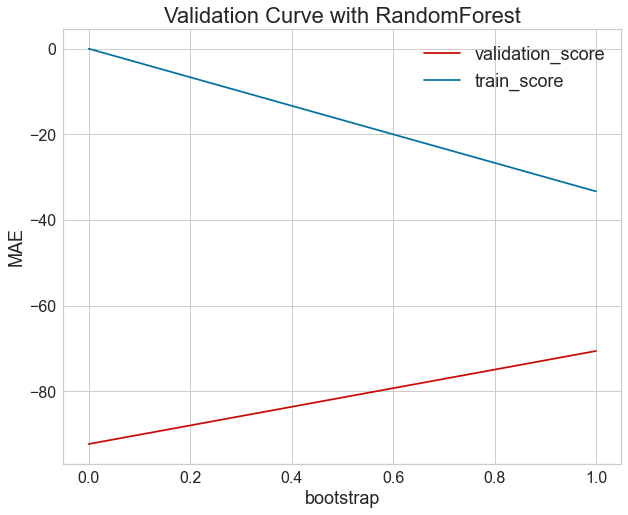

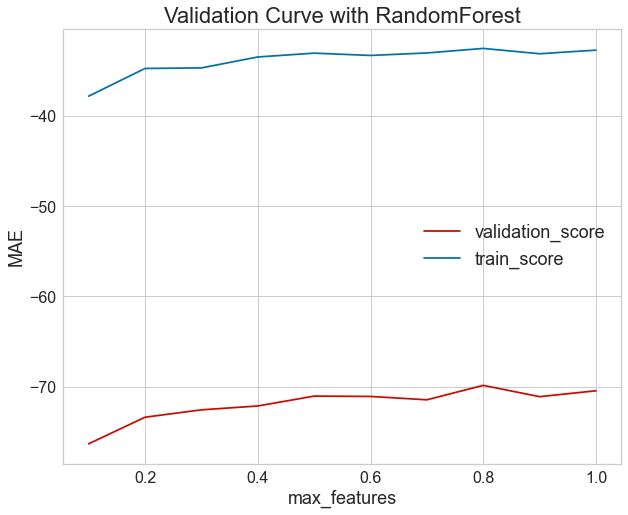

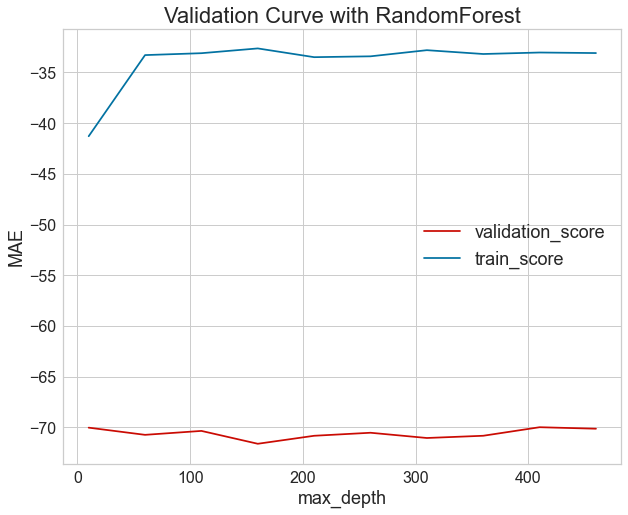

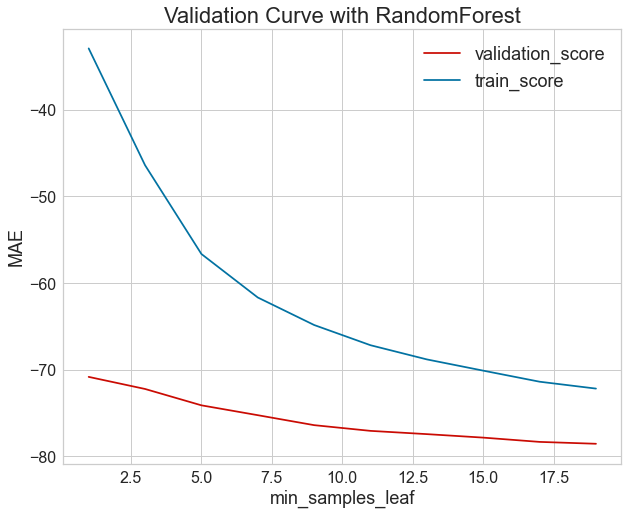

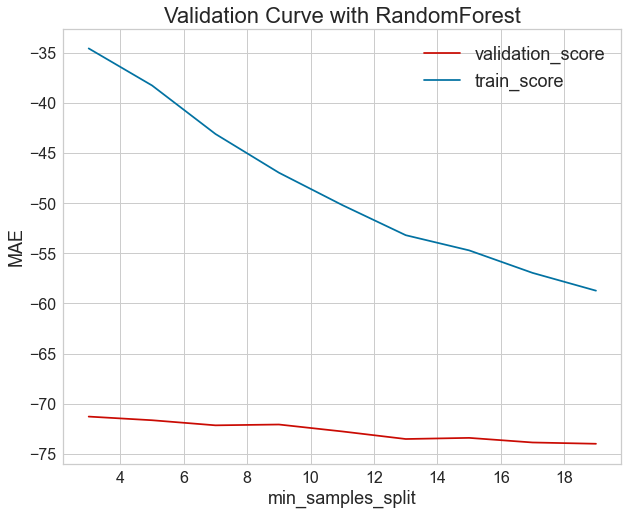

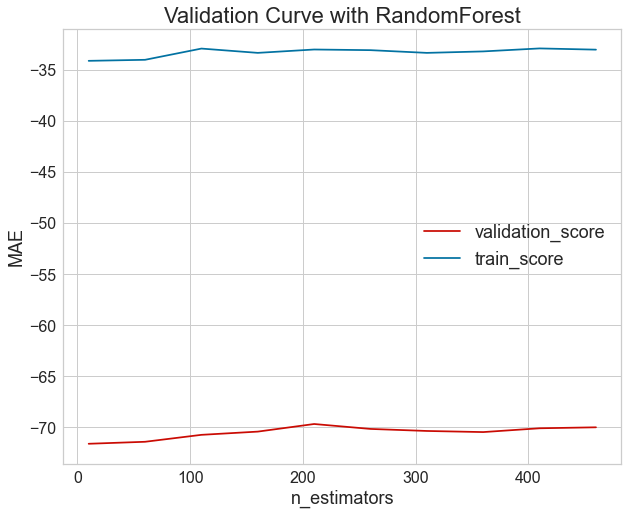

In [85]:
params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : np.linspace(0.1, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth": np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_forest, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with RandomForest', fontsize = 22)

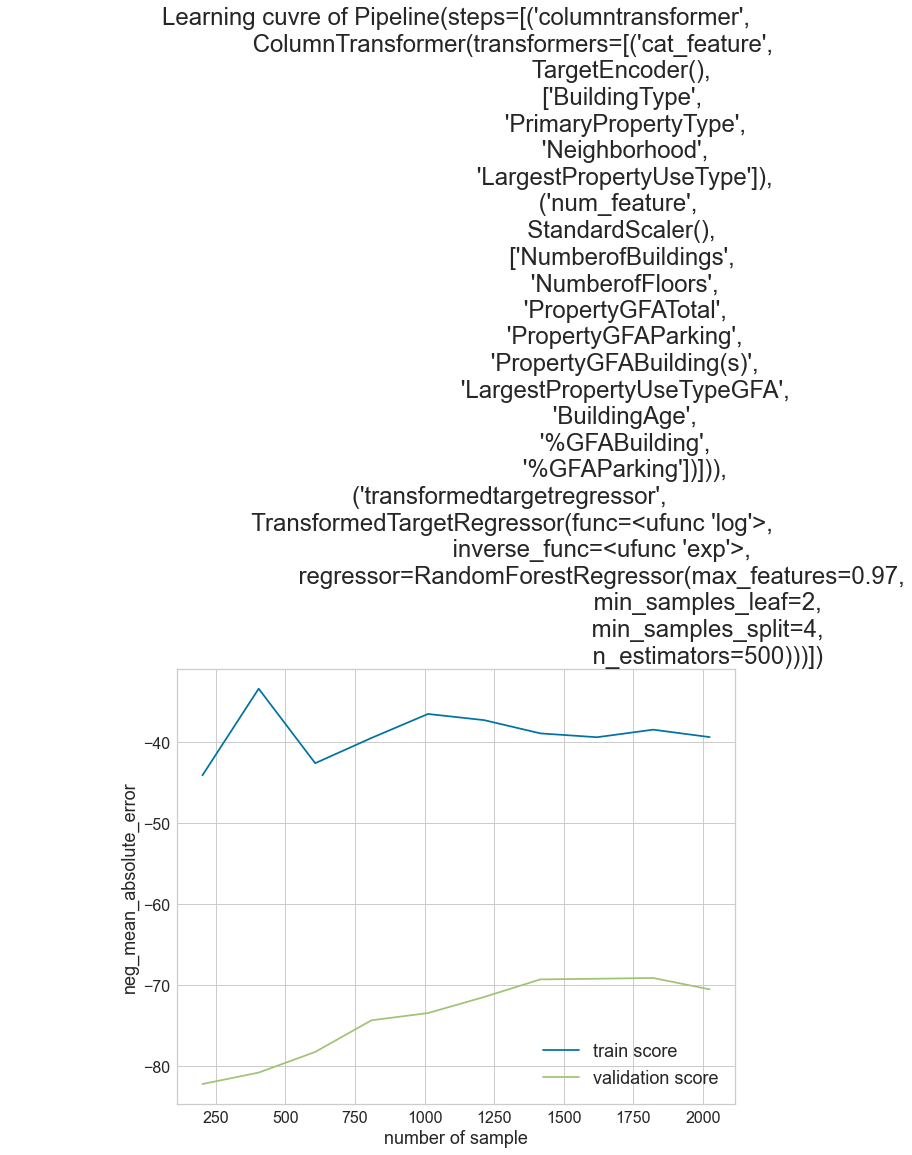

In [86]:
ln_curve(grid_forest.best_estimator_, X_train, y_train)

## B.1.6 Optimisation de model GradientBoosting

In [87]:
start_time = datetime.now()


params = {"transformedtargetregressor__regressor__learning_rate" : [0.01, 0.3, 0.7],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,5, 10],
           "transformedtargetregressor__regressor__min_samples_split" : [2, 5, 10],
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": [0.0, 0.2, 0.4],
          "transformedtargetregressor__regressor__max_depth" : [2 ,5, 10],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_gdb = make_pipeline(preprocessor, regressor)

grid_gdb = GridSearchCV(pre_gdb, param_grid = params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_gdb.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:07:47.129415


In [88]:
gdb_result = model_scores(grid_gdb)

Meilleur score MAE : -68.39
Meilleur Score RMSE: -334.175
Meilleur Score R2 : 0.564
Meilleur Score MAPE: -1.305
Meilleurs paramètres : {'transformedtargetregressor__regressor__learning_rate': 0.3, 'transformedtargetregressor__regressor__max_depth': 2, 'transformedtargetregressor__regressor__min_samples_leaf': 10, 'transformedtargetregressor__regressor__min_samples_split': 2, 'transformedtargetregressor__regressor__min_weight_fraction_leaf': 0.0, 'transformedtargetregressor__regressor__n_estimators': 100}
Temps moyen d'entrainement : 3166.11ms


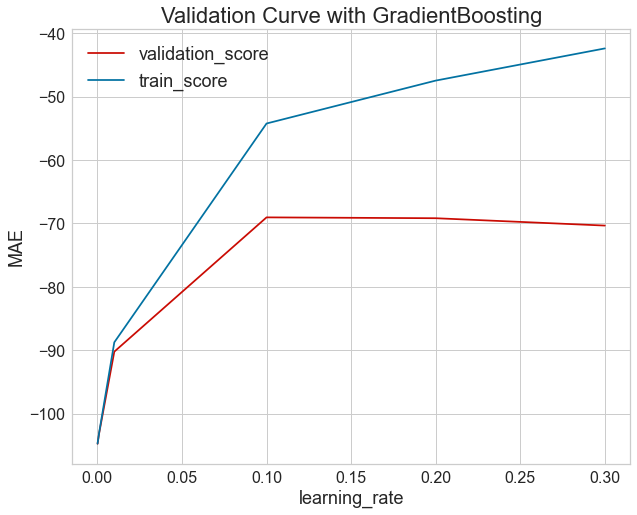

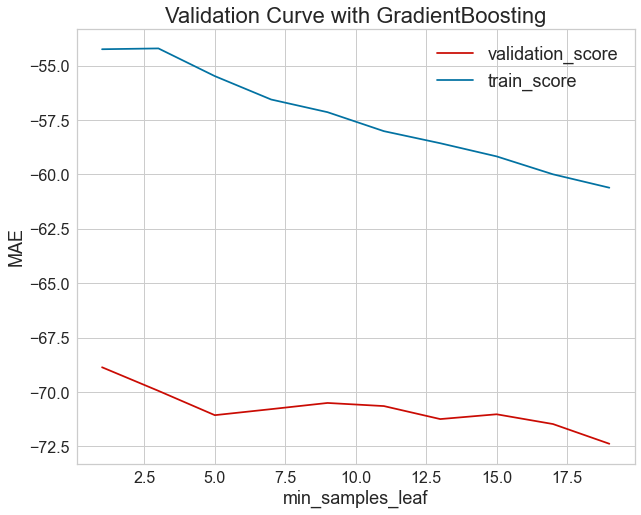

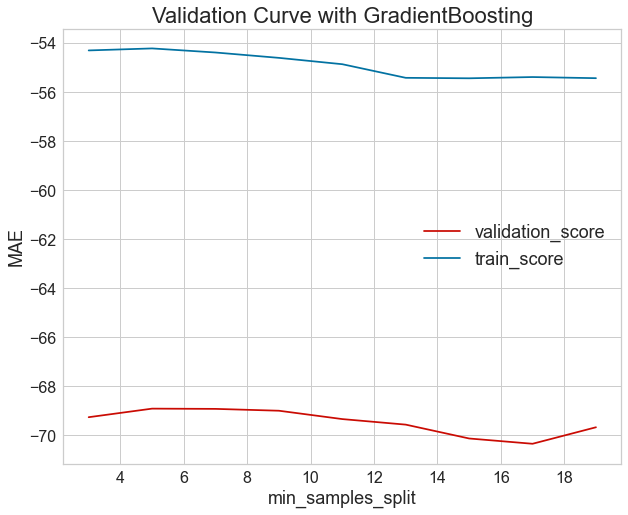

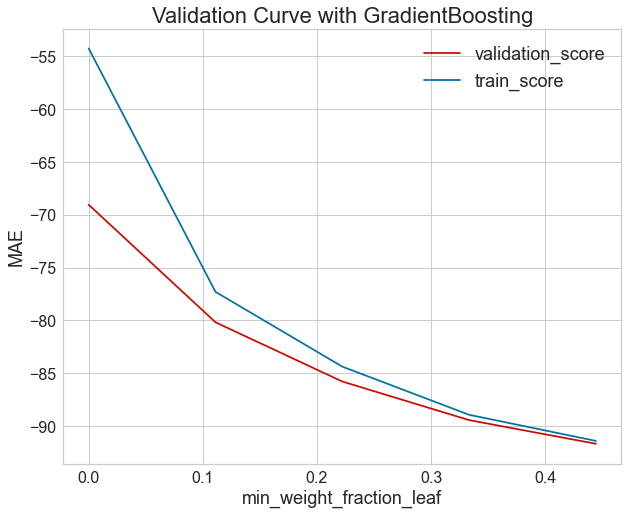

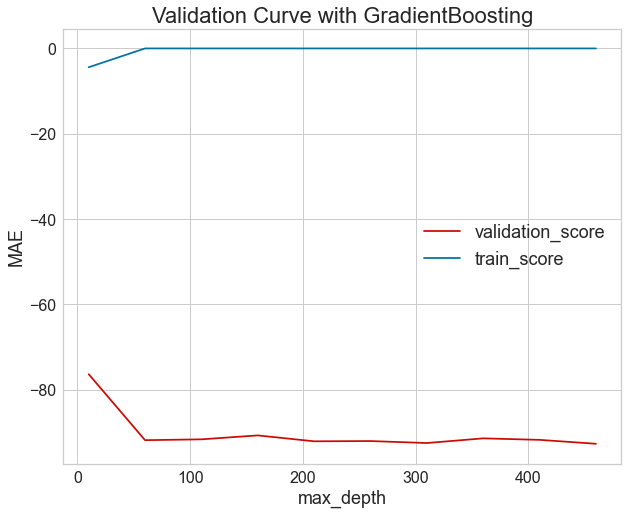

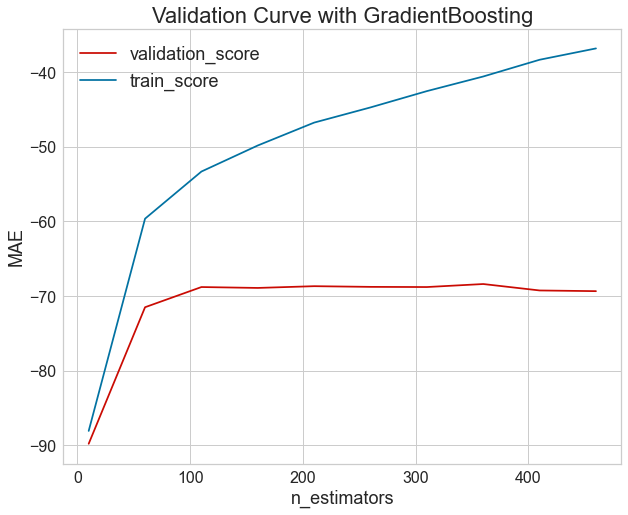

In [89]:

params = {"transformedtargetregressor__regressor__learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": np.linspace(0.0, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth" : np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }


for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_gdb, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with GradientBoosting', fontsize = 22)

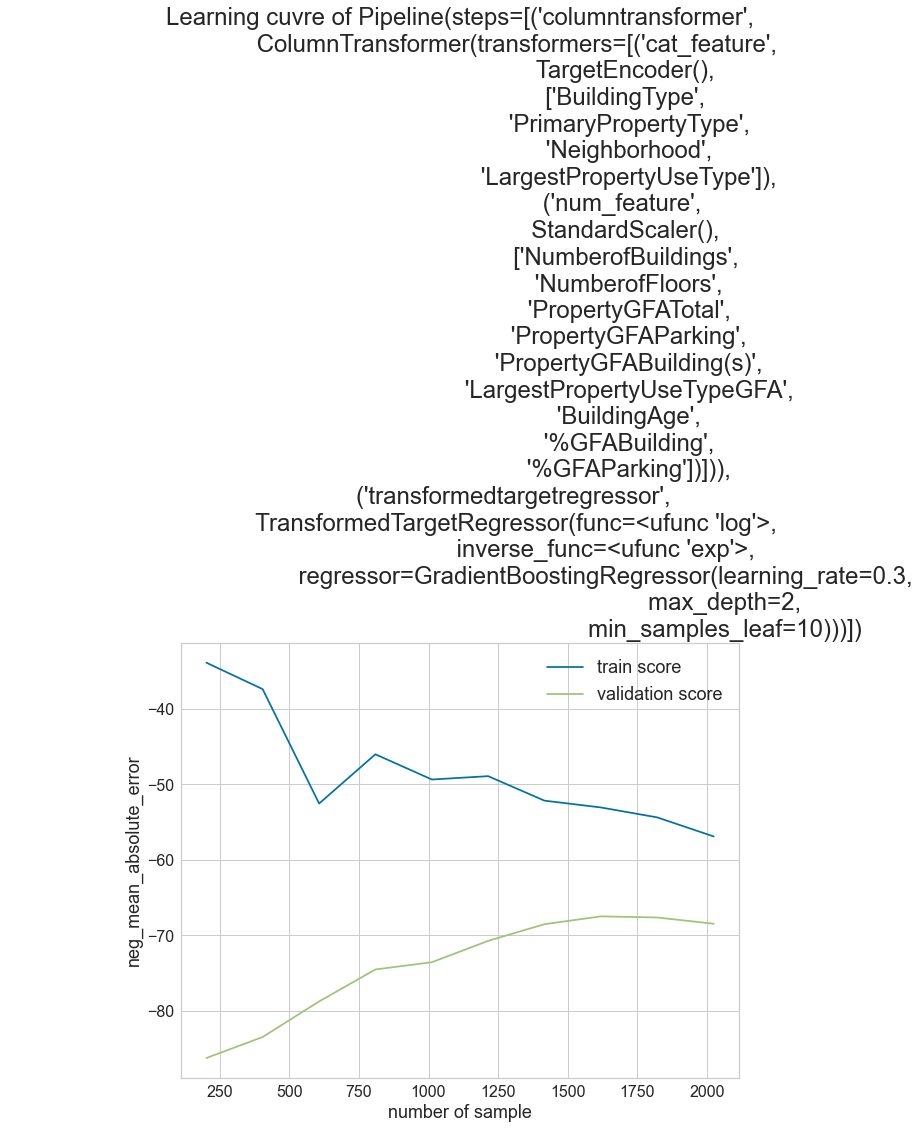

In [90]:
ln_curve(grid_gdb.best_estimator_, X_train, y_train)

## B.1.7 Optimisation de model Bagging

In [103]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_estimators': [10, 50, 100, 300],
          'transformedtargetregressor__regressor__max_samples': [1.0, 0.9, 0.8, 0.5],
          'transformedtargetregressor__regressor__max_features': [1.0, 0.9, 0.8, 0.5]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=BaggingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_bag = make_pipeline(preprocessor, regressor)

grid_bag = GridSearchCV(pre_bag, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_bag.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:03.446635


In [104]:
bag_result = model_scores(grid_bag)

Meilleur score MAE : -69.431
Meilleur Score RMSE: -341.941
Meilleur Score R2 : 0.546
Meilleur Score MAPE: -1.292
Meilleurs paramètres : {'transformedtargetregressor__regressor__max_features': 1.0, 'transformedtargetregressor__regressor__max_samples': 1.0, 'transformedtargetregressor__regressor__n_estimators': 50}
Temps moyen d'entrainement : 4364.64ms


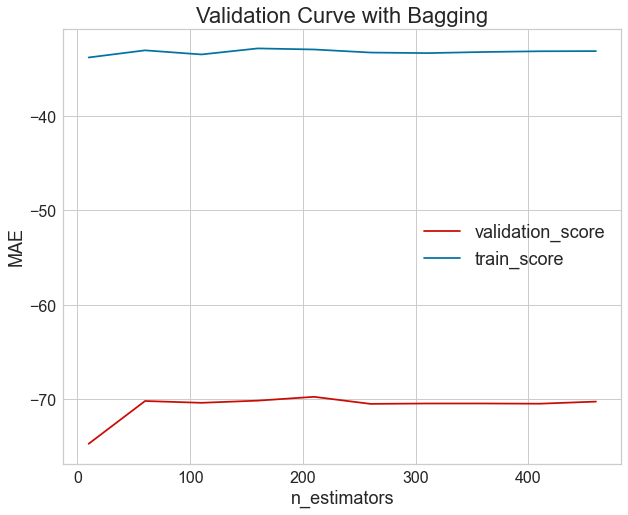

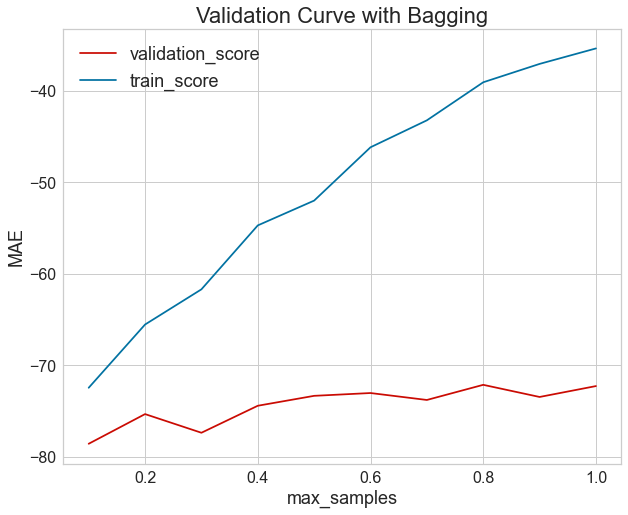

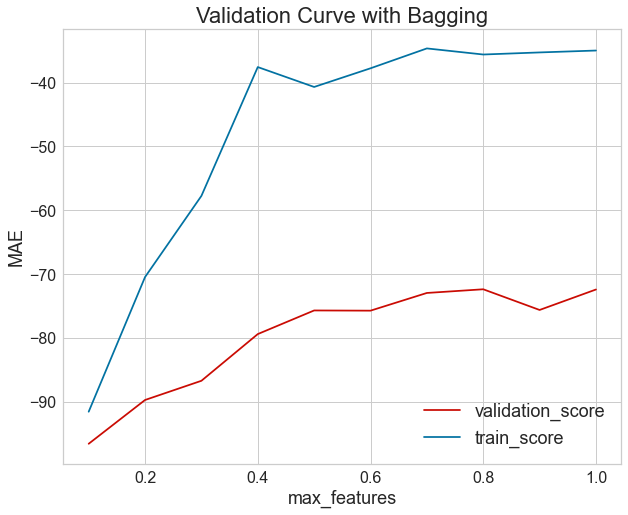

In [105]:
params = {'transformedtargetregressor__regressor__n_estimators': np.arange(10, 500, 50),
          'transformedtargetregressor__regressor__max_samples': np.linspace(0.1, 1.0, 10),
          'transformedtargetregressor__regressor__max_features': np.linspace(0.1, 1.0, 10)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_bag, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with Bagging', fontsize = 22)

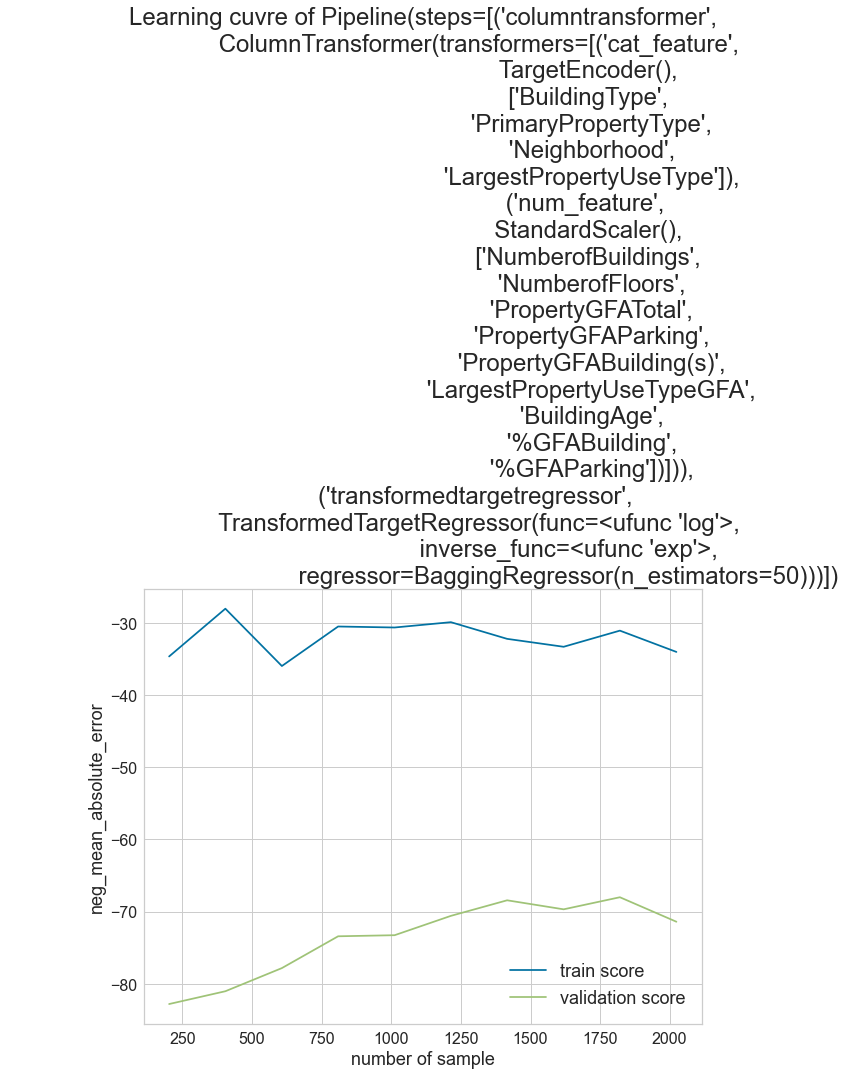

In [106]:
ln_curve(grid_bag.best_estimator_, X_train, y_train)

## B.1.8 Comparer les modèles

In [107]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

model_compare = pd.concat([pd.DataFrame(elas_result[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(knr_result[metrics].mean(), columns=['KNeighbor']),
           pd.DataFrame(bag_result[metrics].mean(), columns=['Bagging']),
           pd.DataFrame(forest_result[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(gdb_result[metrics].mean(), columns=['GradientBoosting'])
          ], axis=1)
final_compare = pd.DataFrame(columns=metrics, 
                                     index=['ElasticNet','KNeighbors',
                                            'Bagging','RandomForest',
                                            'GradientBoosting'])
for m in metrics:
    final_compare[m] = model_compare.loc[m]
    

final_compare = model_compare.T.rename({'mean_fit_time' : 'fit_time', 
                                        'mean_score_time': 'score_time',
                                        'mean_test_neg_mean_absolute_error': 'validation_MAE',
                                        'mean_train_neg_mean_absolute_error': 'train_MAE'},
                                      axis = 1)
final_compare.sort_values('validation_MAE')

fit_time  score_time  validation_MAE   train_MAE
ElasticNet        0.118351    0.032224    -1375.916997 -783.935259
KNeighbor         0.108493    0.056520      -92.335735  -88.617434
GradientBoosting  1.173066    0.036310      -87.575190  -75.055412
RandomForest      3.009911    0.091200      -76.724399  -39.899534
Bagging           1.617133    0.075188      -72.911495  -41.055044

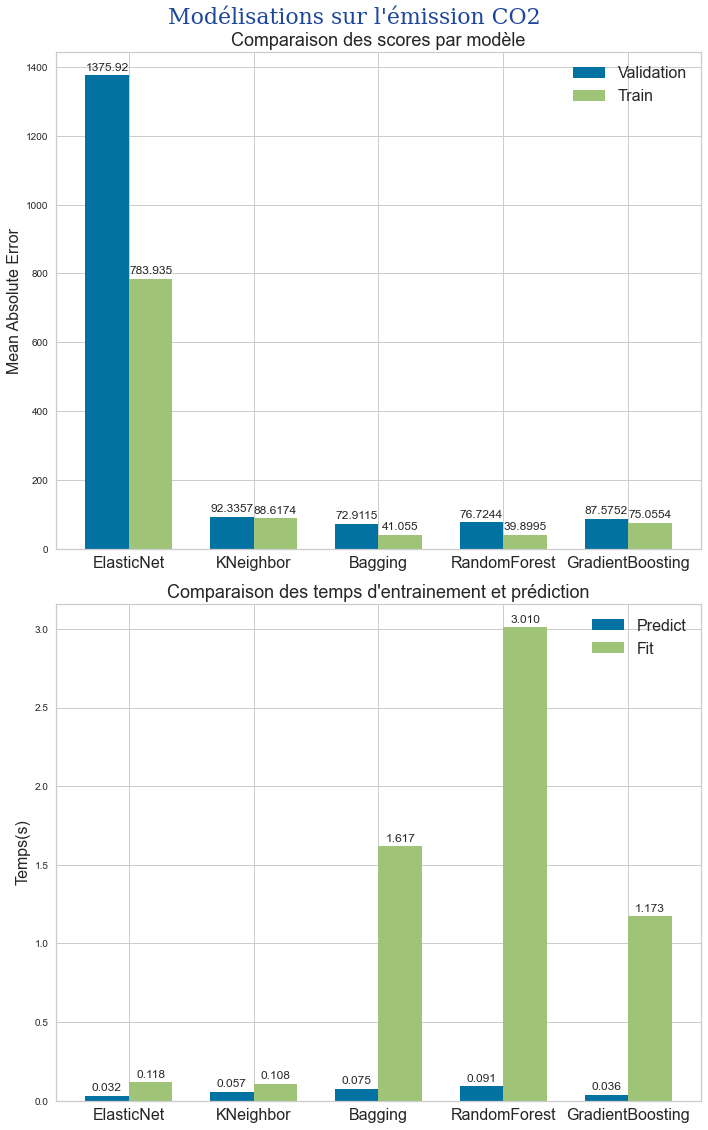

In [108]:
x = np.arange(len(final_compare.index))
width = 0.35

fig, ax = plt.subplots(2,1,figsize=(10,16), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*final_compare['validation_MAE'], width, label='Validation')
scores2 = ax[0].bar(x + width/2, -1*final_compare['train_MAE'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error', fontsize = 16)
ax[0].set_title('Comparaison des scores par modèle', fontsize = 18)
ax[0].set_xticks(x)
ax[0].set_xticklabels(final_compare.index, fontsize = 16)
ax[0].legend(fontsize = 16)
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, final_compare['score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, final_compare['fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)', fontsize = 16)
ax[1].set_title("Comparaison des temps d'entrainement et prédiction", fontsize = 18)
ax[1].set_xticks(x)
ax[1].set_xticklabels(final_compare.index, fontsize = 16)
ax[1].legend(fontsize = 16)
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur l'émission CO2", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

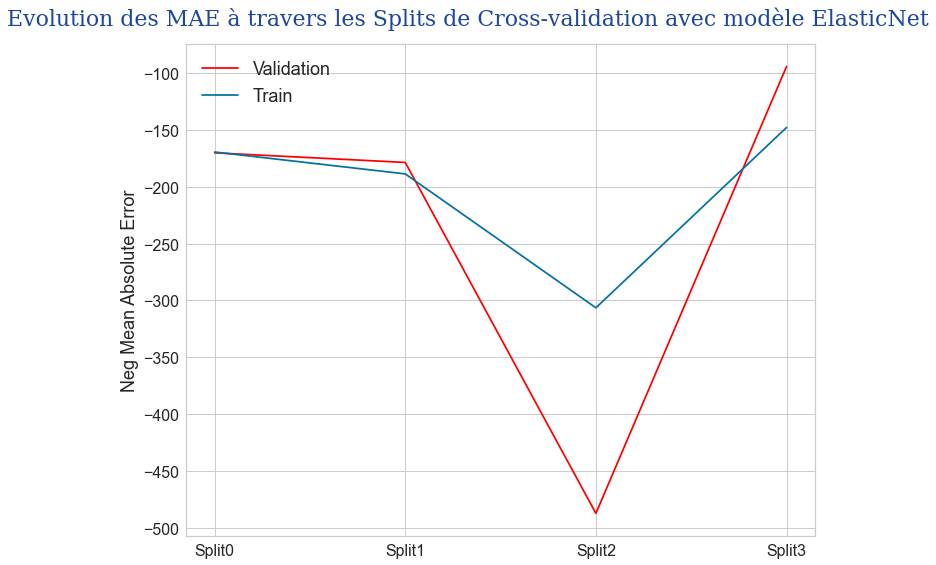

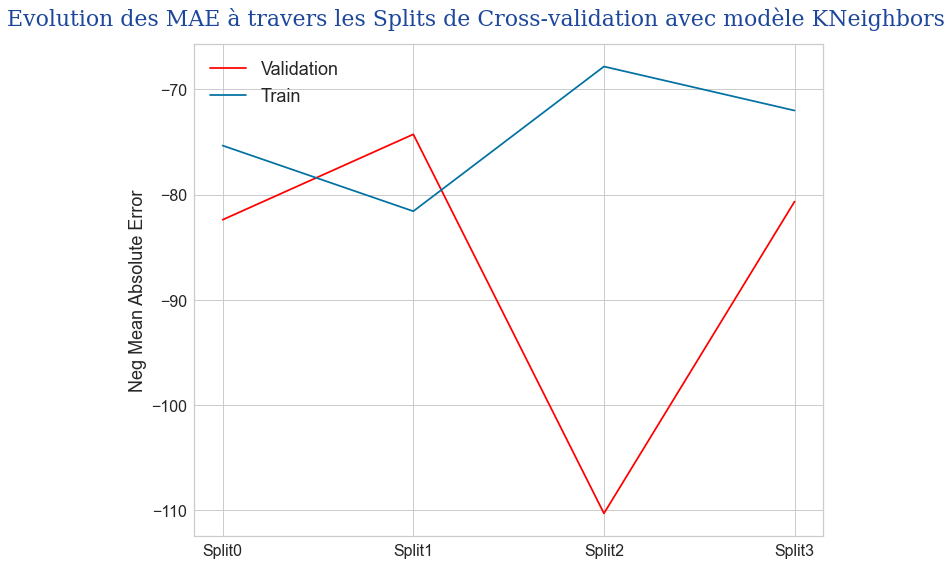

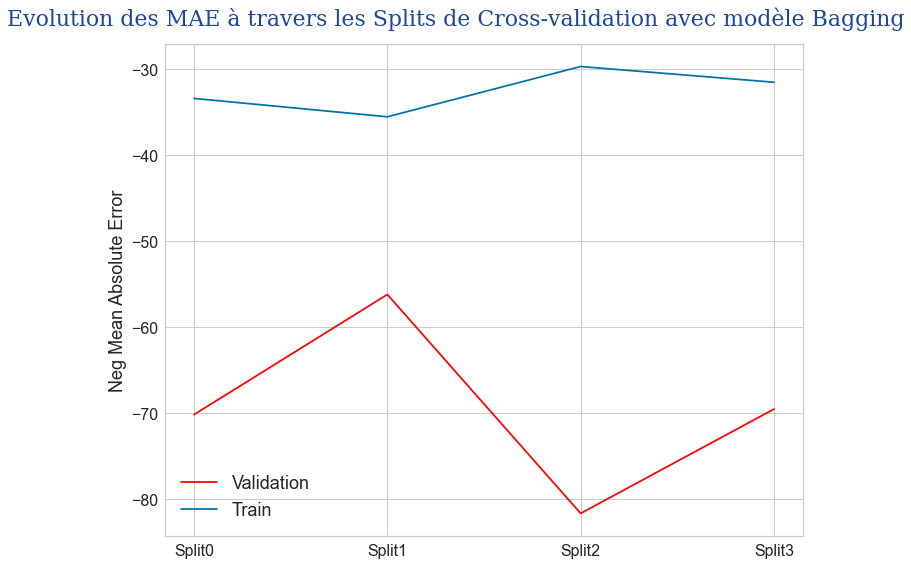

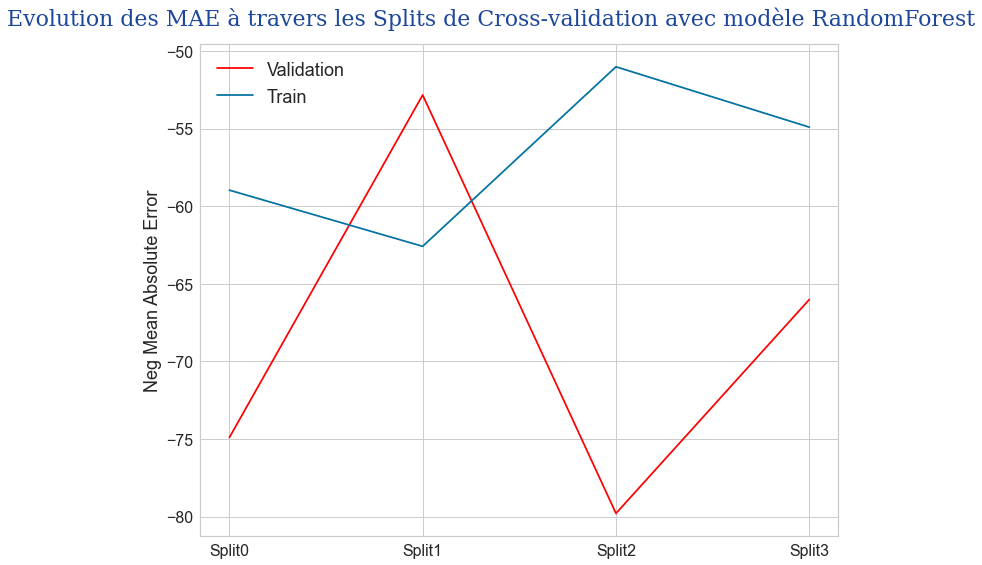

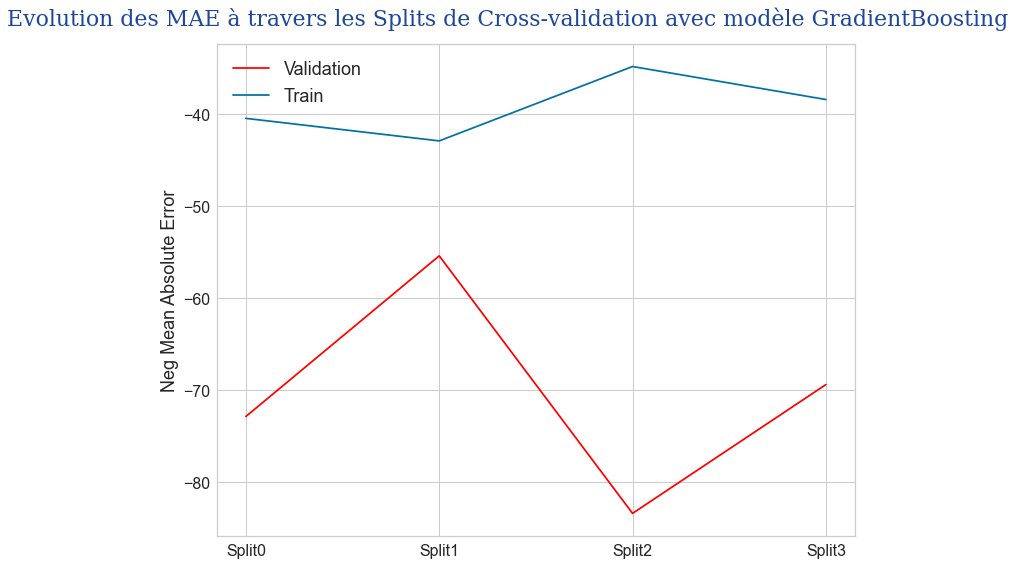

In [109]:
model = ['ElasticNet','KNeighbors','Bagging','RandomForest','GradientBoosting']
i = 0
for result in [elas_result, knr_result, bag_result, gdb_result, forest_result]:

    validation_results = result[['split0_test_neg_mean_absolute_error',
                    'split1_test_neg_mean_absolute_error',
                    'split2_test_neg_mean_absolute_error',
                    'split3_test_neg_mean_absolute_error',
                    #'split4_test_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T
    train_results = result[['split0_train_neg_mean_absolute_error',
                    'split1_train_neg_mean_absolute_error',
                    'split2_train_neg_mean_absolute_error',
                    'split3_train_neg_mean_absolute_error',
                    #'split4_train_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T


    x = np.arange(0,4,1)
    fig, ax = plt.subplots(figsize=(10,8), sharey=False, sharex=False)
    ax.plot(range(0,4), validation_results.iloc[:, 0], c = 'red', label = 'Validation')
    ax.set_xticks(x)
    plt.yticks(fontsize = 16)
    ax.set_xticklabels(["Split"+str(n) for n in range(0,4)], fontsize = 16)
    ax.set_ylabel('Neg Mean Absolute Error', fontsize = 18)

    ax.plot(range(0,4), train_results.iloc[:, 0], color='b', label = 'Train')
    
    ax.legend(fontsize = 18)


    plt.suptitle(f"Evolution des MAE à travers les Splits de Cross-validation avec modèle {model[i]}", fontdict=font_title, fontsize=22)
    i= i +1
    fig.tight_layout()

    plt.show()

# B.1.9 Prédire avec le modèle choisi (Bagging)

In [113]:
score_final(grid_bag, X_test, y_test)

MAE     RMSE     R²  \
GridSearchCV(cv=4,\n             estimator=Pipe...  69.099  193.281  0.695   

                                                     MAPE  \
GridSearchCV(cv=4,\n             estimator=Pipe...  1.276   

                                                             execute time  
GridSearchCV(cv=4,\n             estimator=Pipe... 0 days 00:00:00.027864

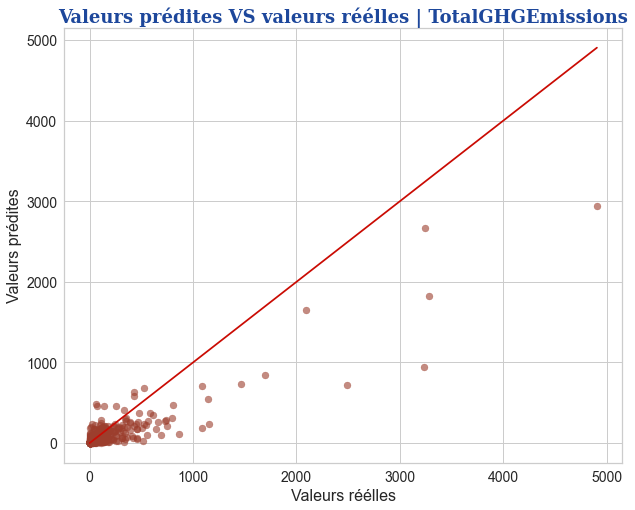

In [111]:
plot_pred_true(y_test,grid_bag.best_estimator_.predict(X_test), color="#9C3E2D", title="TotalGHGEmissions")

# B.1.10 Features importantes avec Bagging

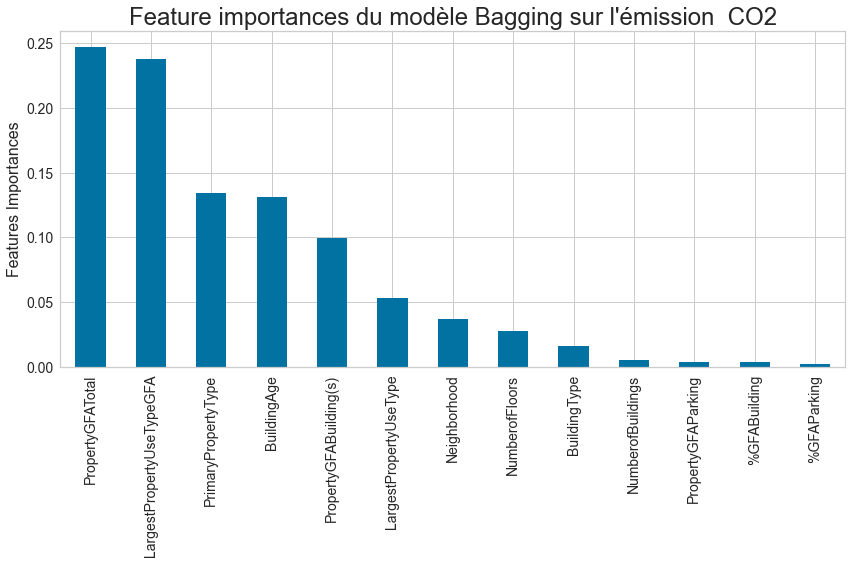

In [112]:

feature_importance = np.mean([tree.feature_importances_ for tree in\
                              grid_bag.best_estimator_.named_steps['transformedtargetregressor']\
                              .regressor_.estimators_], axis=0)
feature_names = cat_feature + num_feature


df_feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar()
ax.set_title("Feature importances du modèle Bagging sur l'émission  CO2",
             fontsize = 24)
ax.set_ylabel("Features Importances", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks( fontsize = 14)
fig.tight_layout()

# B.2 Avec EnergyStarScore

In [114]:
cat_feature = []
for col in data.select_dtypes(['object', 'category']):    
    cat_feature.append(col)

    
num_feature = []
for col in data.select_dtypes(['float64', 'int64']):
    num_feature.append(col)
    
num_feature.remove('TotalGHGEmissions')
num_feature.remove('SiteEnergyUse(kBtu)')

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 

In [115]:
train_set, test_set = train_test_split(data, 
                                       test_size=0.2,
                                       random_state=rd_state, stratify = data['PrimaryPropertyType'])

y_train = train_set[['TotalGHGEmissions']]
y_test = test_set[['TotalGHGEmissions']]
X_train = train_set.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
X_test = test_set.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)

In [116]:
from datetime import datetime

start_time = datetime.now()

resume = evalution(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

resume

Duration: 0:00:41.592531


MAE      RMSE      R²   MAPE           execute time
ElasticNet       -233.461 -2344.215 -18.891 -3.941 0 days 00:00:01.614985
DecisionTree     -100.798  -538.199  -0.717 -1.972 0 days 00:00:01.381985
Dummy Regressor  -104.935  -517.117  -0.033 -2.599 0 days 00:00:01.141111
SVM               -94.096  -475.262   0.133 -2.488 0 days 00:00:08.803827
Kneighbors        -98.376  -430.832    0.22 -2.232 0 days 00:00:01.283902
Bagging           -71.347  -365.951   0.466 -1.131 0 days 00:00:03.456363
Random Forest     -69.671  -358.082   0.503 -1.117 0 days 00:00:17.278203
GradientBoosting  -67.713  -340.048   0.559 -1.083 0 days 00:00:06.629070

## B.2.2 Essaies avec feature engineering

In [117]:
regressor = TransformedTargetRegressor(regressor=gdboost,
                                       func=np.log,
                                       inverse_func=np.exp)
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
start_time = datetime.now()

feature_engineering = make_pipeline(preprocessor, 
                                    PolynomialFeatures(include_bias=False),
                                    SelectKBest(f_regression), 
                                    PCA(),
                                    regressor)


params = {'polynomialfeatures__degree': [1, 2],
         'selectkbest__k': [10, 4, 7, 13],
         'pca__n_components': [0.97, 0.9, 0.8, 0.6]
          #'transformedtargetregressor__regressor__min_samples_split': [2, 5, 10], 
          #'transformedtargetregressor__regressor__max_features' : [0.8, 1.0, 0.9],
          #'transformedtargetregressor__regressor__n_estimators' : [10, 100, 500],
          #'transformedtargetregressor__regressor__min_samples_leaf' : [2, 3, 5]
        }

grid_feature = GridSearchCV(feature_engineering, param_grid =params, 
                            scoring = ('neg_mean_absolute_error',
                                       'neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_percentage_error'),
                            refit='neg_mean_absolute_error',
                            cv = 4, n_jobs=-1)
grid_feature.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

Duration: 0:00:08.020759


In [118]:
feature_result = model_scores(grid_feature)

Meilleur score MAE : -77.524
Meilleur Score RMSE: -349.553
Meilleur Score R2 : 0.521
Meilleur Score MAPE: -1.586
Meilleurs paramètres : {'pca__n_components': 0.97, 'polynomialfeatures__degree': 2, 'selectkbest__k': 4}
Temps moyen d'entrainement : 1096.53ms


## B.2.3 Optimisation de model Elastic

In [119]:
start_time = datetime.now()

params = {"transformedtargetregressor__regressor__max_iter": [10, 100, 1000],
          "transformedtargetregressor__regressor__alpha": np.arange(0.0, 1, 0.1),
          "transformedtargetregressor__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=ElasticNet(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_elas = make_pipeline(preprocessor, regressor)

grid_elas = GridSearchCV(pre_elas, param_grid =params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_elas.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1363.513514289542, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advis

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1362.7731976281557, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advi

  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1418.9889439007932, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.1251892620176, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1472.7643684775064, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470.8536212432703, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: U

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470.

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470.8536212432703, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may l

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1472.7643684775064, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might wa

  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1410.7368125364787, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.1251892620176, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.regressor_.fit(X, y_trans, **fit_params)
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1472.7643684775064, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:207: UserWarning: With alpha=0, this algorithm does not converge well. You are adv

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.1251892620176, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1445.4826710389539, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1498.430850884286, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pac

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 972.0452225888814, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1385.074676290852, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 957.8181597398819, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packag

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1415.036849386063, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1142.8364236589164, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1456.7269085808666, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.7562628862761, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1200.69905564744, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1132.5416996199474, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1537.9751643027596, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1393.6161790146232, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1485.1475822315128, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.15103730980854, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 825.5302739943938, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.920347913444402, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1240.3525738011779, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872.6450040242886, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1130.6599359249635, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pac

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.042020211833915, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.390682286678384, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.9607639738515, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-package

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.181082829900333, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.3909684329492, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334.16286485913747, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1475.3804100885168, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1507.967432099929, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1579.550201205349, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.589330916242488, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.695863586968699, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.45314013551524, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.0810412713823, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1486.4158363632143, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1330.7511053612852, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.82058824767819, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.813144341852876, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.56536152269382, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-package

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1600.9939025644776, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1547.1071111769247, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1547.075702875071, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pac

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3103714395956558, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8640656136581129, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.6128063547203, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packa

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.760519456888687, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.74944360808786, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1310.3897442822802, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1084260882744275, tolerance: 0.4438986792421611
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7929507465260031, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.41745023104522, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pack

Duration: 0:00:37.518003


/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7364100813156256, tolerance: 0.46325316504159475
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6358624365770993, tolerance: 0.45738457958958073
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.513211807117386, tolerance: 0.45443589156865405
  model = cd_fast.enet_coordinate_descent(
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-pa

In [120]:
elas_result = model_scores(grid_elas)

Meilleur score MAE : -232.554
Meilleur Score RMSE: -2339.277
Meilleur Score R2 : -18.719
Meilleur Score MAPE: -2.057
Meilleurs paramètres : {'transformedtargetregressor__regressor__alpha': 0.5, 'transformedtargetregressor__regressor__l1_ratio': 1.0, 'transformedtargetregressor__regressor__max_iter': 100}
Temps moyen d'entrainement : 310.95ms


## B.2.4 Optimisation de model KNeighbors

In [121]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_neighbors': [int(x) for x in np.linspace(1, 100, 100)]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=KNeighborsRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_knr = make_pipeline(preprocessor, regressor)

grid_knr = GridSearchCV(pre_knr, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)



grid_knr.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:14.824196


In [122]:
knr_result = model_scores(grid_knr)

Meilleur score MAE : -87.033
Meilleur Score RMSE: -418.531
Meilleur Score R2 : 0.305
Meilleur Score MAPE: -1.736
Meilleurs paramètres : {'transformedtargetregressor__regressor__n_neighbors': 5}
Temps moyen d'entrainement : 259.07ms


## B.2.5 Optimisation de model RandomForestRegressor

In [123]:
start_time = datetime.now()


params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : [0.97, 1.0, 0.9],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,3,4],
           "transformedtargetregressor__regressor__min_samples_split" : [2,3,4],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_forest = make_pipeline(preprocessor, regressor)

grid_forest = GridSearchCV(pre_forest, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_forest.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:04:37.383688


In [124]:
forest_result = model_scores(grid_forest)

Meilleur score MAE : -69.697
Meilleur Score RMSE: -339.292
Meilleur Score R2 : 0.528
Meilleur Score MAPE: -1.109
Meilleurs paramètres : {'transformedtargetregressor__regressor__bootstrap': True, 'transformedtargetregressor__regressor__max_features': 0.97, 'transformedtargetregressor__regressor__min_samples_leaf': 2, 'transformedtargetregressor__regressor__min_samples_split': 4, 'transformedtargetregressor__regressor__n_estimators': 100}
Temps moyen d'entrainement : 8520.81ms


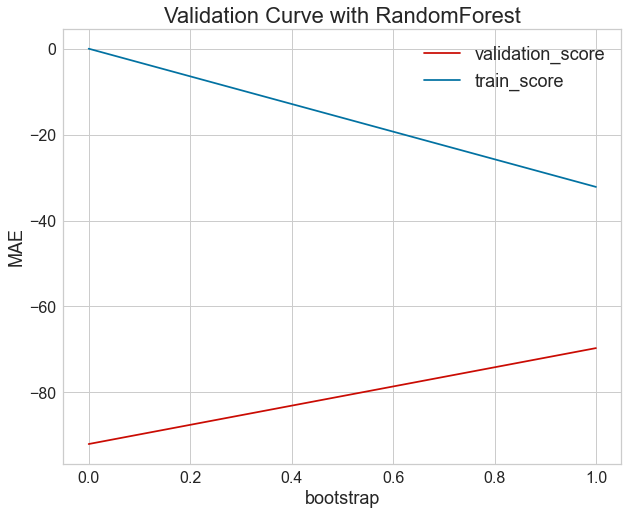

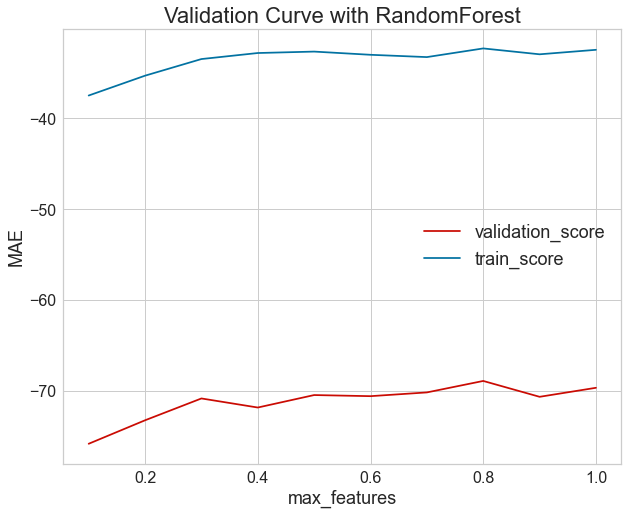

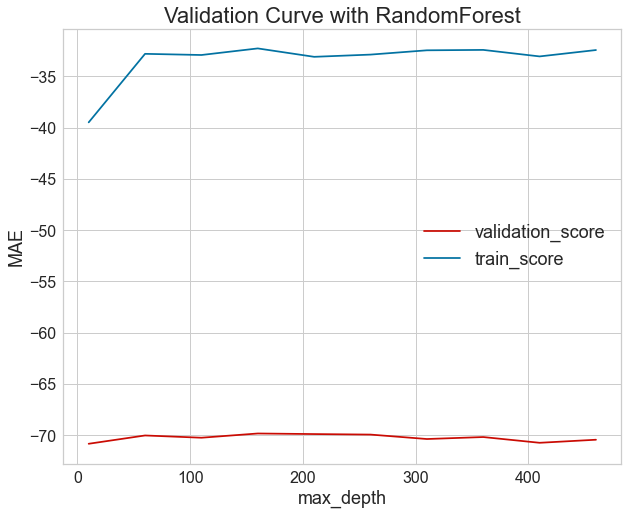

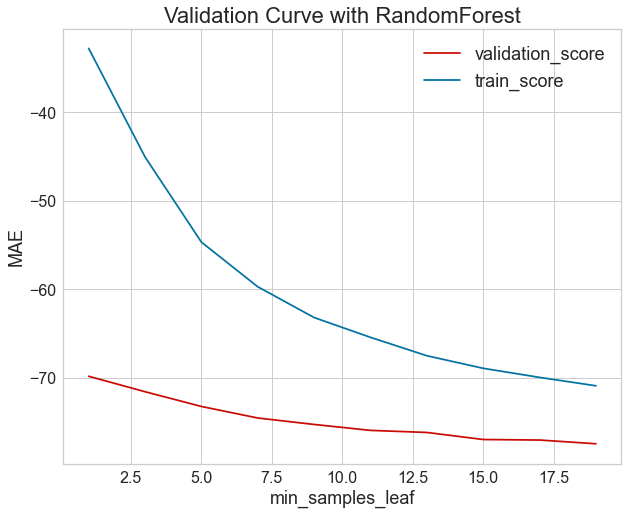

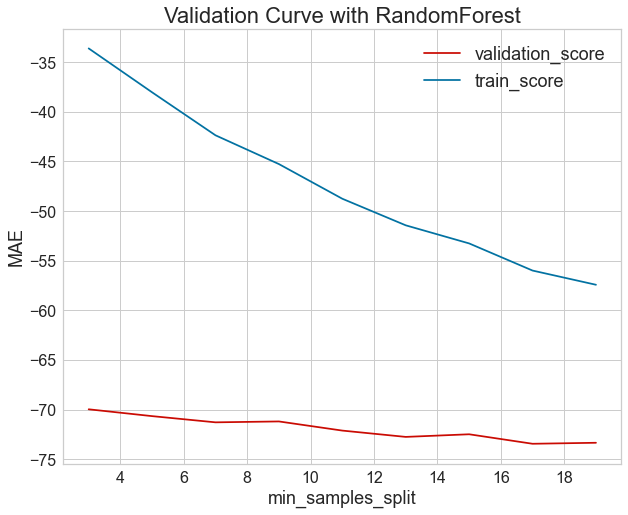

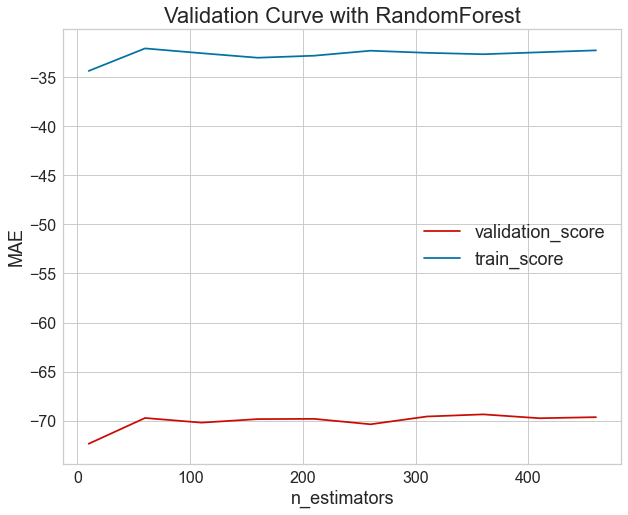

In [125]:
params = {"transformedtargetregressor__regressor__bootstrap":[True, False],
           "transformedtargetregressor__regressor__max_features" : np.linspace(0.1, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth": np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_forest, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with RandomForest', fontsize = 22)

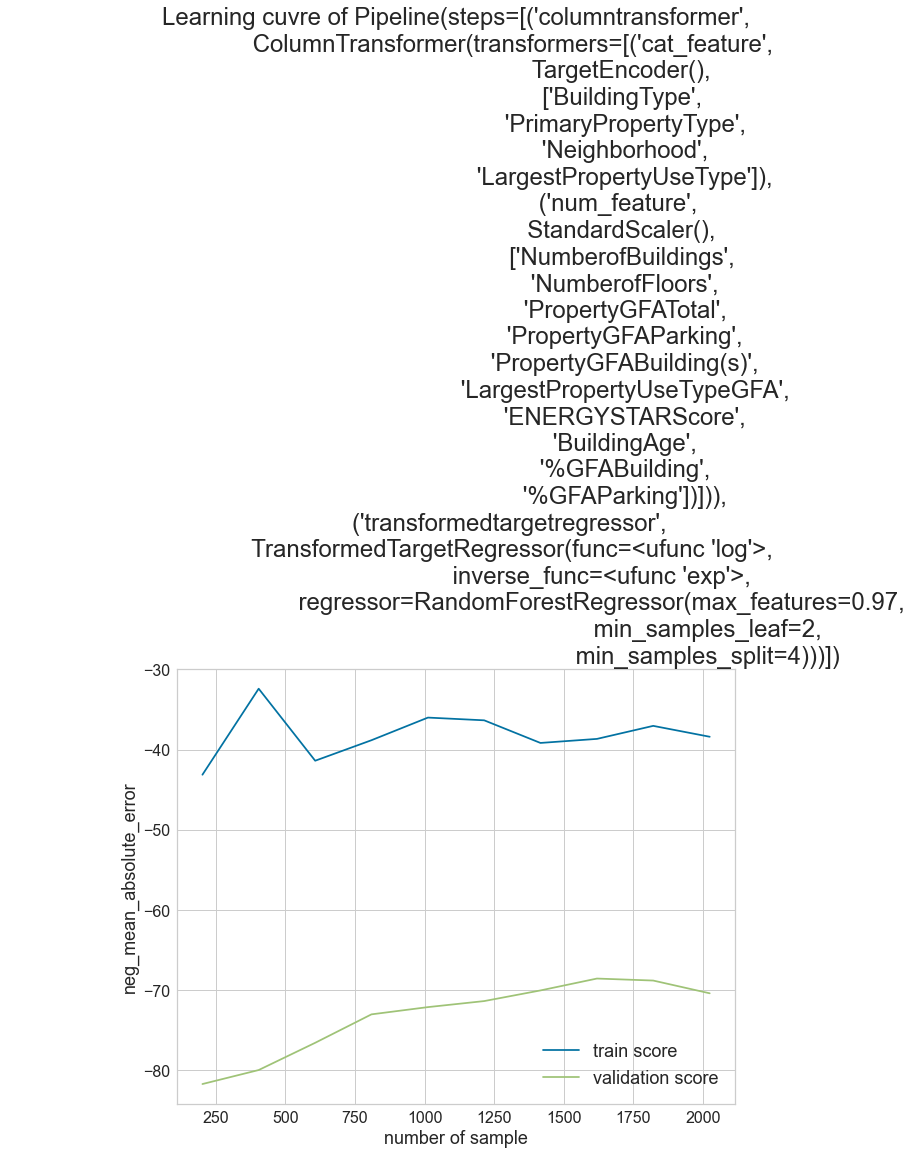

In [126]:
ln_curve(grid_forest.best_estimator_, X_train, y_train)

## B.2.6 Optimisation de model GradientBoosting

In [127]:
start_time = datetime.now()


params = {"transformedtargetregressor__regressor__learning_rate" : [0.01, 0.3, 0.7],
           "transformedtargetregressor__regressor__min_samples_leaf" : [2,5, 10],
           "transformedtargetregressor__regressor__min_samples_split" : [2, 5, 10],
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": [0.0, 0.2, 0.4],
          "transformedtargetregressor__regressor__max_depth" : [2 ,5, 10],
           "transformedtargetregressor__regressor__n_estimators" : [10, 100, 500]
         }
preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_gdb = make_pipeline(preprocessor, regressor)

grid_gdb = GridSearchCV(pre_gdb, param_grid = params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_gdb.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:07:17.442222


In [128]:
gdb_result = model_scores(grid_gdb)

Meilleur score MAE : -66.95
Meilleur Score RMSE: -319.804
Meilleur Score R2 : 0.605
Meilleur Score MAPE: -1.067
Meilleurs paramètres : {'transformedtargetregressor__regressor__learning_rate': 0.3, 'transformedtargetregressor__regressor__max_depth': 2, 'transformedtargetregressor__regressor__min_samples_leaf': 2, 'transformedtargetregressor__regressor__min_samples_split': 10, 'transformedtargetregressor__regressor__min_weight_fraction_leaf': 0.0, 'transformedtargetregressor__regressor__n_estimators': 100}
Temps moyen d'entrainement : 3002.81ms


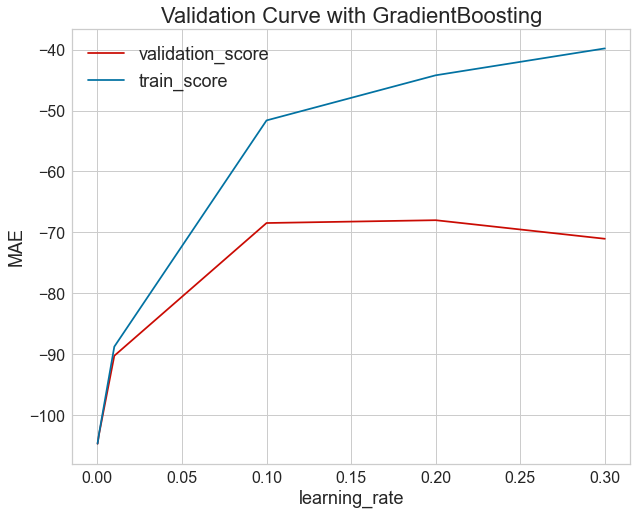

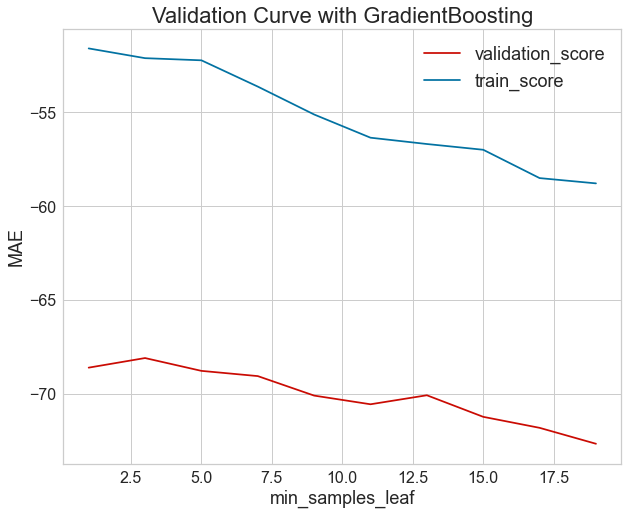

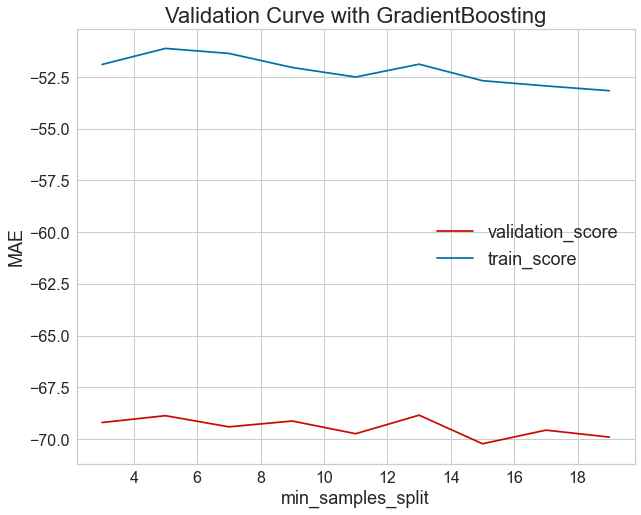

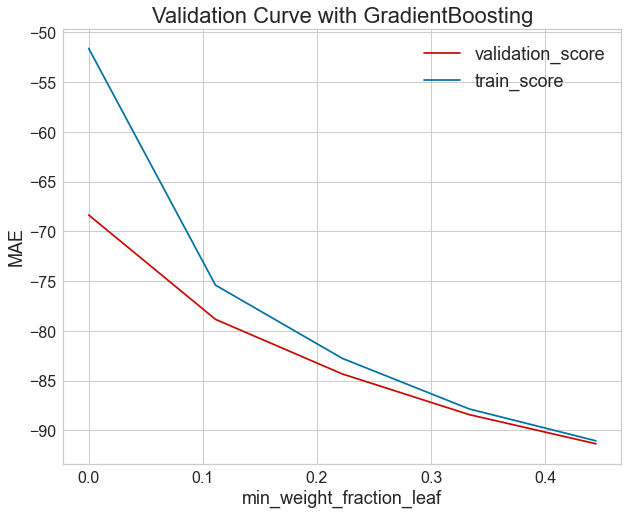

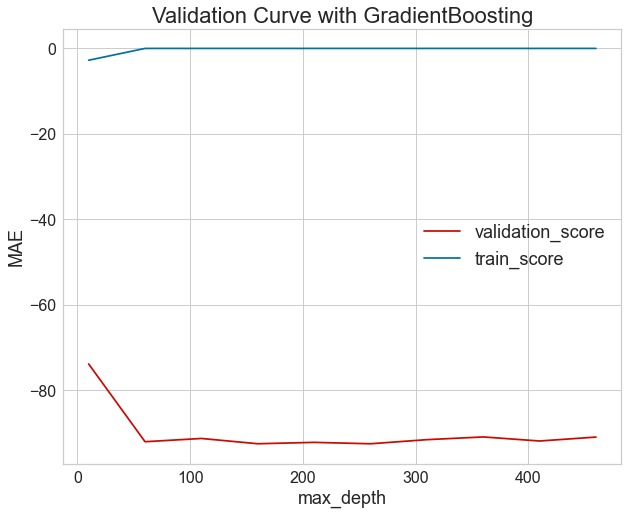

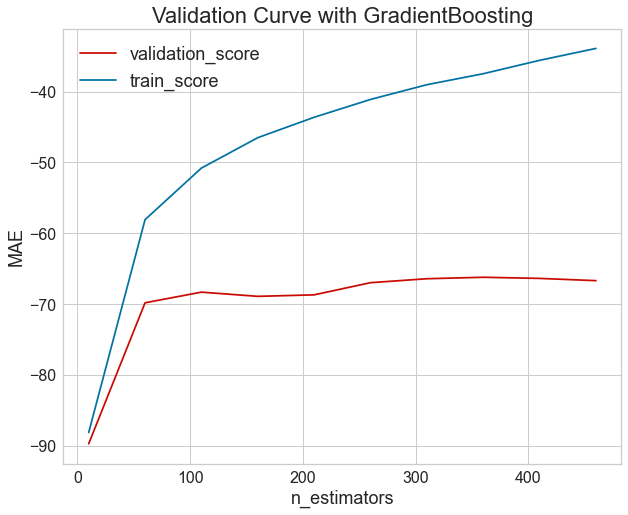

In [129]:

params = {"transformedtargetregressor__regressor__learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
           "transformedtargetregressor__regressor__min_samples_leaf" : np.arange(1, 20, 2),
           "transformedtargetregressor__regressor__min_samples_split" : np.arange(1, 20, 2),
          "transformedtargetregressor__regressor__min_weight_fraction_leaf": np.linspace(0.0, 1.0, 10),
          "transformedtargetregressor__regressor__max_depth" : np.arange(10, 500, 50),
           "transformedtargetregressor__regressor__n_estimators" : np.arange(10, 500, 50)
         }


for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_gdb, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with GradientBoosting', fontsize = 22)

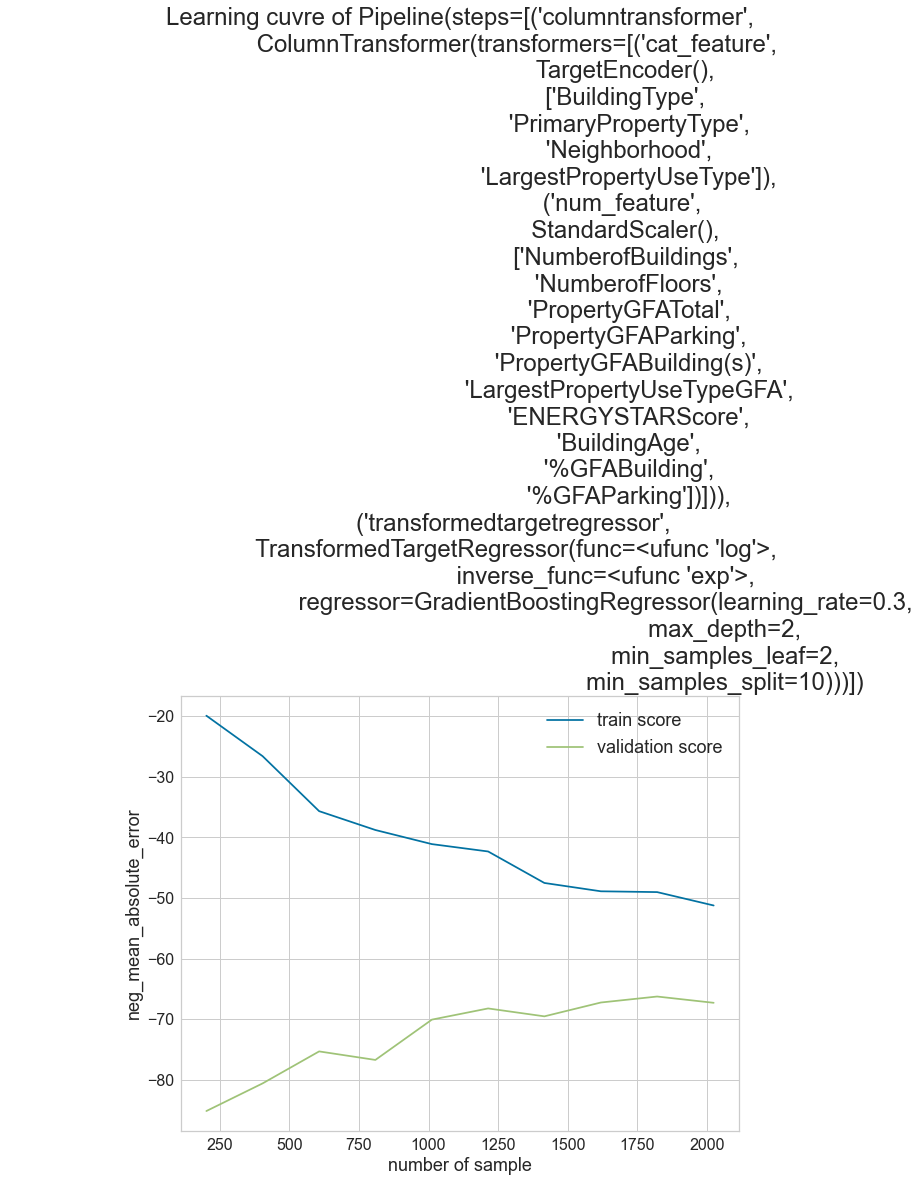

In [130]:
ln_curve(grid_gdb.best_estimator_, X_train, y_train)

## B.2.7 Optimisation de model Bagging

In [131]:
start_time = datetime.now()


params = {'transformedtargetregressor__regressor__n_estimators': [10, 50, 100],
          'transformedtargetregressor__regressor__max_samples': [1.0, 0.9, 0.8],
          'transformedtargetregressor__regressor__max_features': [1.0, 0.9, 0.8]
         }

preprocessor = ColumnTransformer(transformers=[('cat_feature', encoder_TE, cat_feature),
                                               ('num_feature', scaler_std, num_feature)]) 
regressor = TransformedTargetRegressor(regressor=BaggingRegressor(),
                                       func=np.log,
                                       inverse_func=np.exp)

pre_bag = make_pipeline(preprocessor, regressor)

grid_bag = GridSearchCV(pre_bag, param_grid=params, cv=4,
                        scoring = ('neg_mean_absolute_error','neg_mean_squared_error',
                                   'neg_root_mean_squared_error', 'r2',
                                   'neg_mean_absolute_percentage_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs=-1)

grid_bag.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:14.942463


In [132]:
bag_result = model_scores(grid_bag)

Meilleur score MAE : -69.021
Meilleur Score RMSE: -349.906
Meilleur Score R2 : 0.518
Meilleur Score MAPE: -1.098
Meilleurs paramètres : {'transformedtargetregressor__regressor__max_features': 1.0, 'transformedtargetregressor__regressor__max_samples': 0.9, 'transformedtargetregressor__regressor__n_estimators': 50}
Temps moyen d'entrainement : 2377.27ms


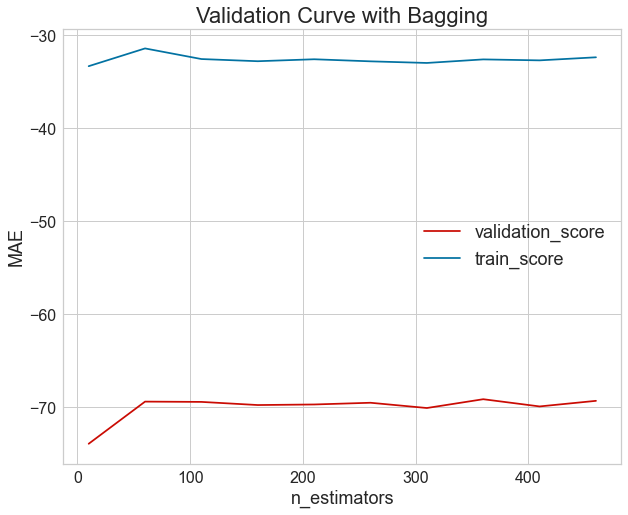

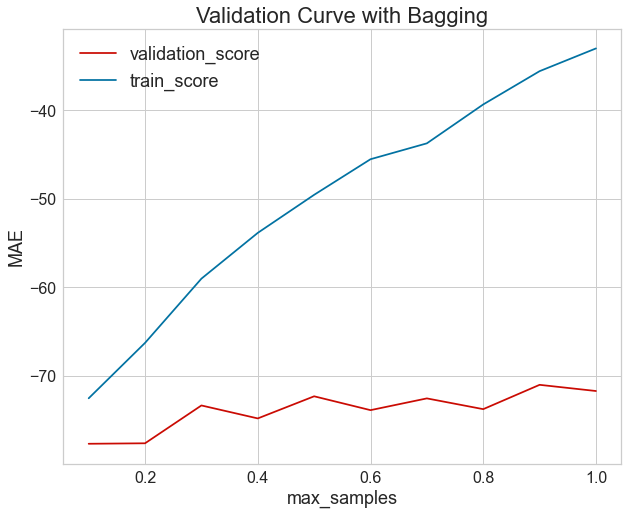

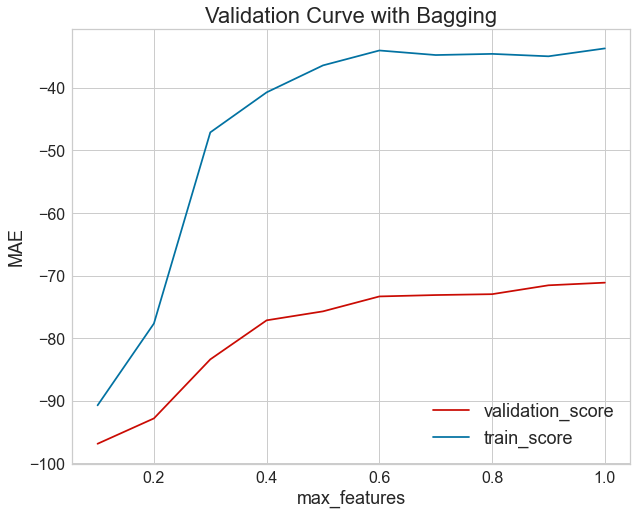

In [133]:
params = {'transformedtargetregressor__regressor__n_estimators': np.arange(10, 500, 50),
          'transformedtargetregressor__regressor__max_samples': np.linspace(0.1, 1.0, 10),
          'transformedtargetregressor__regressor__max_features': np.linspace(0.1, 1.0, 10)
         }
for hyperP, value in params.items():

    train_score, val_score = validation_curve(pre_bag, X_train, y_train, hyperP, value,
                                              scoring = 'neg_mean_absolute_error',
                                              cv =4)
    
    plt.figure(figsize=(10, 8))
    plt.plot(value, val_score.mean(axis =1), c = 'r', label = 'validation_score')
    plt.plot(value, train_score.mean(axis = 1), c = 'b', label = 'train_score')
    plt.xticks(fontsize = 16)
    plt.xlabel(f'{hyperP[39:]}', fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylabel('MAE', fontsize = 18)
    plt.legend(fontsize = 18)
    plt.title('Validation Curve with Bagging', fontsize = 22)

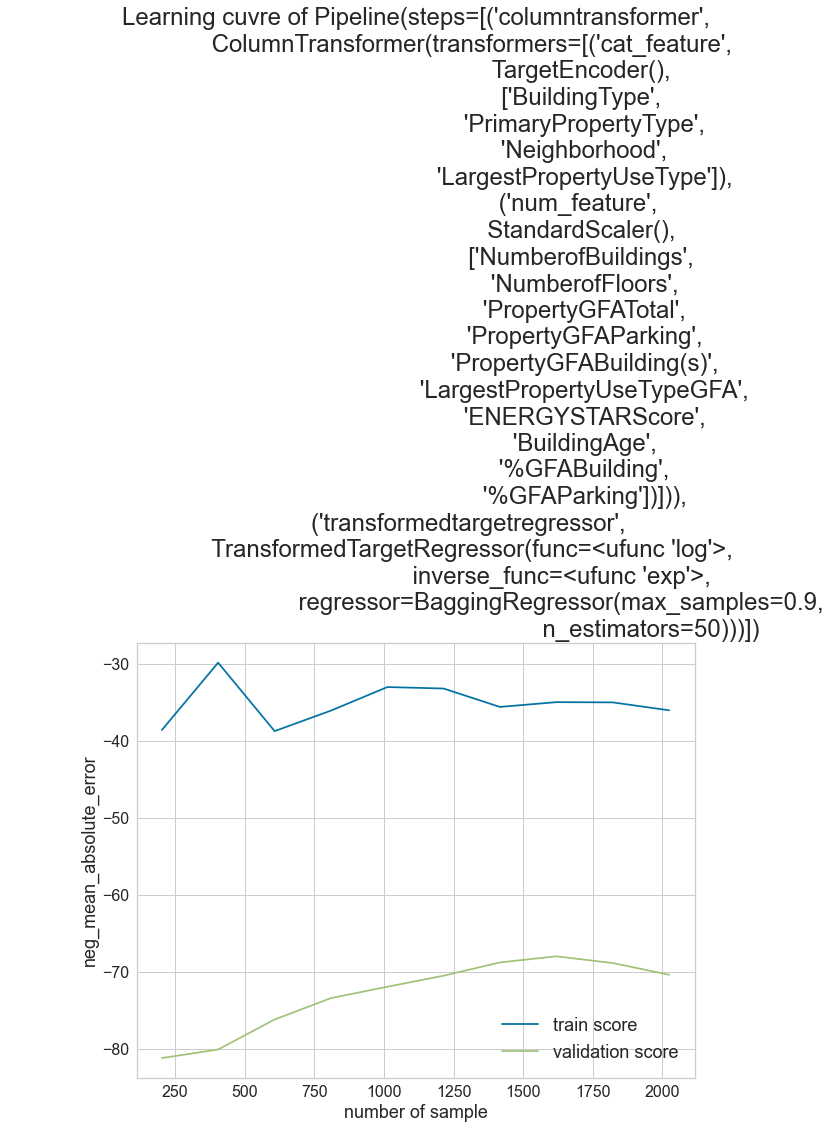

In [134]:
ln_curve(grid_bag.best_estimator_, X_train, y_train)

## B.2.8 Comparer les modèle

In [135]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

model_compare = pd.concat([pd.DataFrame(elas_result[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(knr_result[metrics].mean(), columns=['KNeighbor']),
           pd.DataFrame(bag_result[metrics].mean(), columns=['Bagging']),
           pd.DataFrame(forest_result[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(gdb_result[metrics].mean(), columns=['GradientBoosting'])
          ], axis=1)
final_compare = pd.DataFrame(columns=metrics, 
                                     index=['ElasticNet','KNeighbors',
                                            'Bagging','RandomForest',
                                            'GradientBoosting'])
for m in metrics:
    final_compare[m] = model_compare.loc[m]
    

final_compare = model_compare.T.rename({'mean_fit_time' : 'fit_time', 
                                        'mean_score_time': 'score_time',
                                        'mean_test_neg_mean_absolute_error': 'validation_MAE',
                                        'mean_train_neg_mean_absolute_error': 'train_MAE'},
                                      axis = 1)
final_compare.sort_values('validation_MAE')

fit_time  score_time  validation_MAE   train_MAE
ElasticNet        0.115209    0.032033    -1395.010989 -756.612196
KNeighbor         0.095989    0.051407      -92.473686  -88.729333
GradientBoosting  1.112564    0.031808      -86.955799  -73.957237
RandomForest      3.157024    0.084188      -76.808864  -37.923613
Bagging           0.880798    0.046080      -70.984258  -36.217043

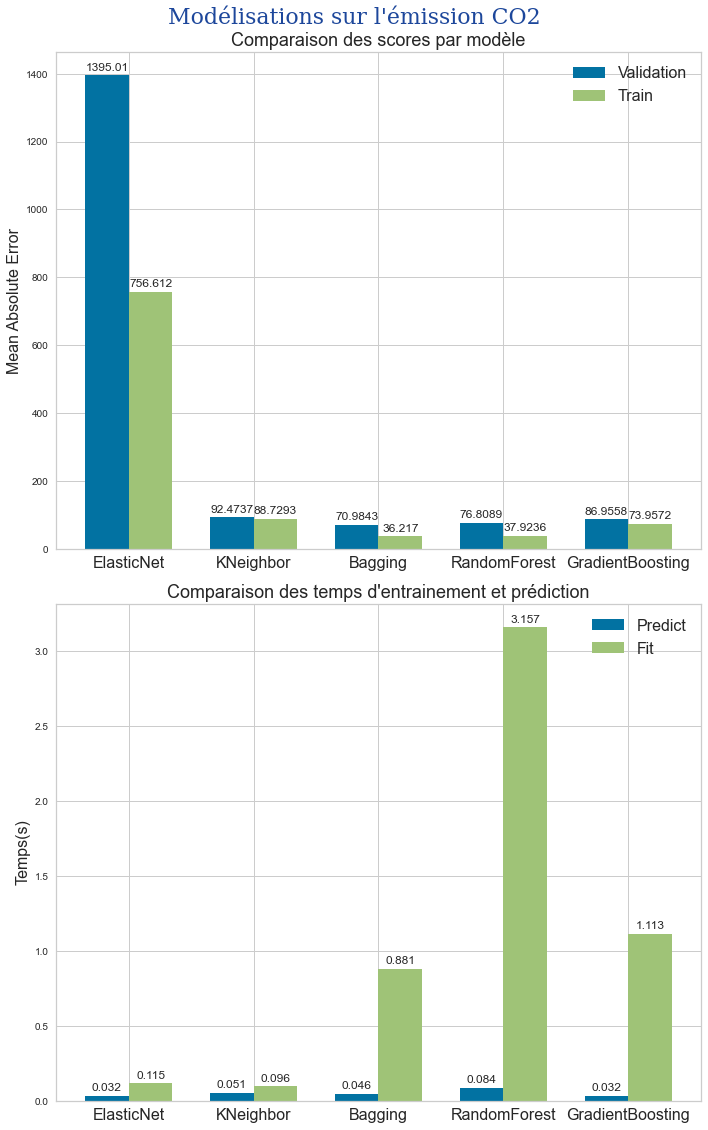

In [136]:
x = np.arange(len(final_compare.index))
width = 0.35

fig, ax = plt.subplots(2,1,figsize=(10,16), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*final_compare['validation_MAE'], width, label='Validation')
scores2 = ax[0].bar(x + width/2, -1*final_compare['train_MAE'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error', fontsize = 16)
ax[0].set_title('Comparaison des scores par modèle', fontsize = 18)
ax[0].set_xticks(x)
ax[0].set_xticklabels(final_compare.index, fontsize = 16)
ax[0].legend(fontsize = 16)
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, final_compare['score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, final_compare['fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)', fontsize = 16)
ax[1].set_title("Comparaison des temps d'entrainement et prédiction", fontsize = 18)
ax[1].set_xticks(x)
ax[1].set_xticklabels(final_compare.index, fontsize = 16)
ax[1].legend(fontsize = 16)
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur l'émission CO2", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

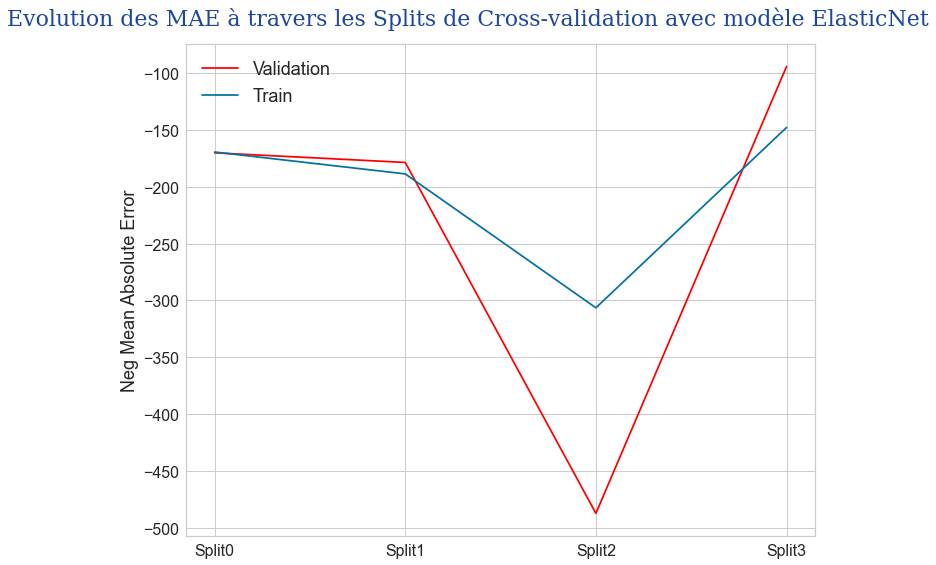

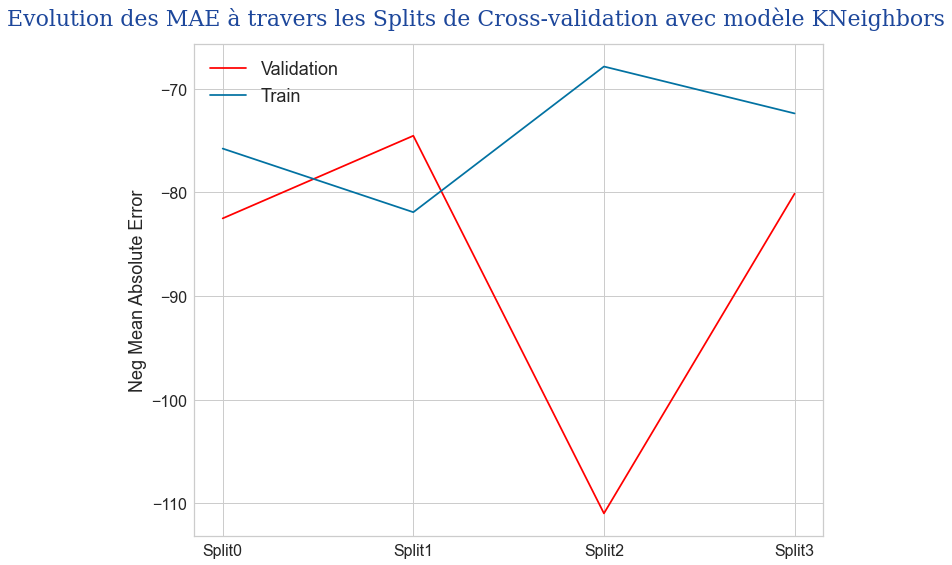

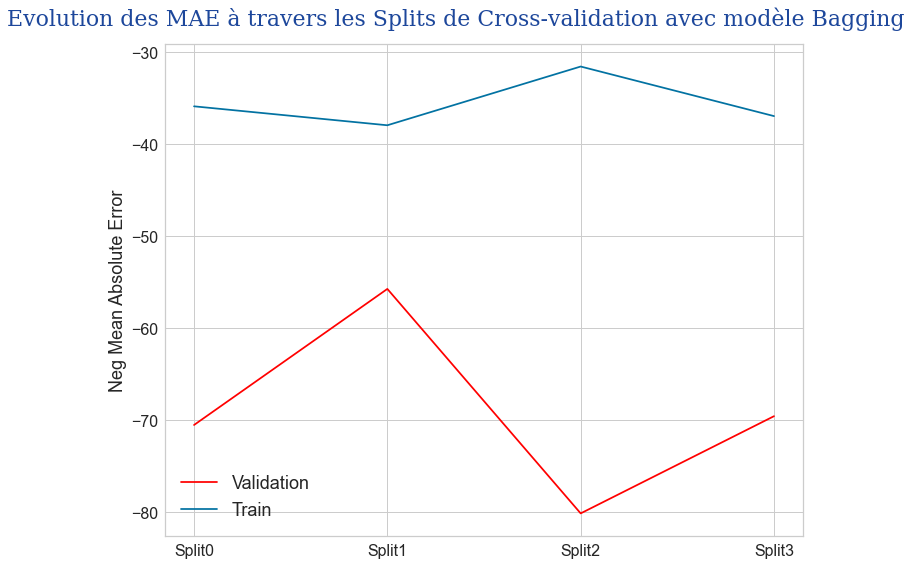

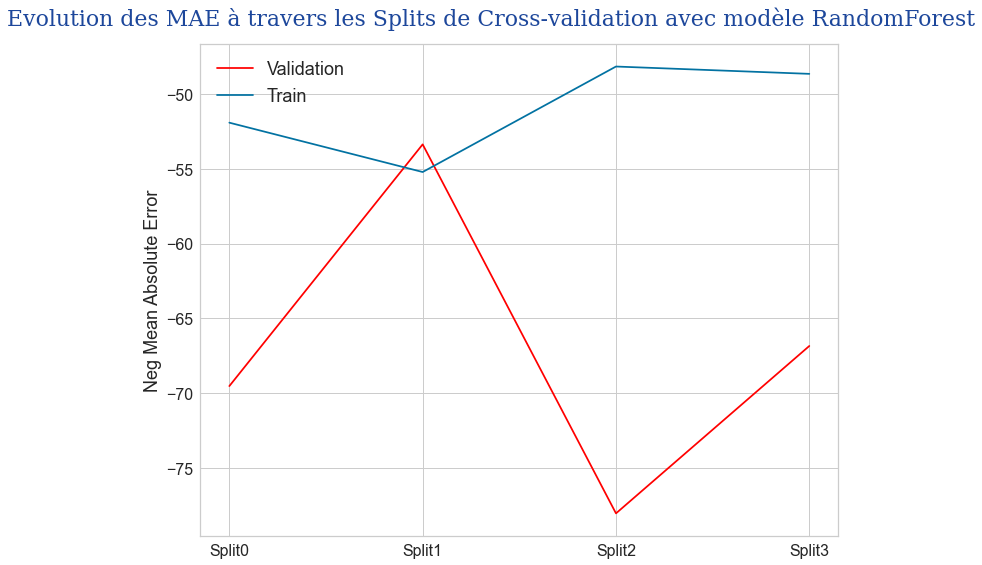

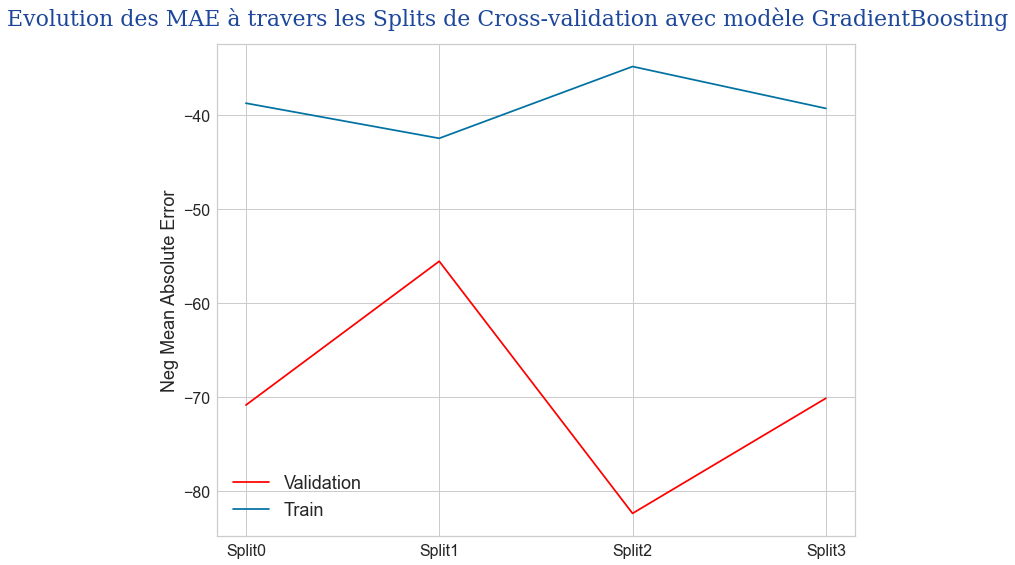

In [137]:
model = ['ElasticNet','KNeighbors','Bagging','RandomForest','GradientBoosting']
i = 0
for result in [elas_result, knr_result, bag_result, gdb_result, forest_result]:

    validation_results = result[['split0_test_neg_mean_absolute_error',
                    'split1_test_neg_mean_absolute_error',
                    'split2_test_neg_mean_absolute_error',
                    'split3_test_neg_mean_absolute_error',
                    #'split4_test_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T
    train_results = result[['split0_train_neg_mean_absolute_error',
                    'split1_train_neg_mean_absolute_error',
                    'split2_train_neg_mean_absolute_error',
                    'split3_train_neg_mean_absolute_error',
                    #'split4_train_neg_mean_absolute_error',
                    ]][result['rank_test_neg_mean_absolute_error']==1].T


    x = np.arange(0,4,1)
    fig, ax = plt.subplots(figsize=(10,8), sharey=False, sharex=False)
    ax.plot(range(0,4), validation_results.iloc[:, 0], c = 'red', label = 'Validation')
    ax.set_xticks(x)
    plt.yticks(fontsize = 16)
    ax.set_xticklabels(["Split"+str(n) for n in range(0,4)], fontsize = 16)
    ax.set_ylabel('Neg Mean Absolute Error', fontsize = 18)

    ax.plot(range(0,4), train_results.iloc[:, 0], color='b', label = 'Train')
    
    ax.legend(fontsize = 18)


    plt.suptitle(f"Evolution des MAE à travers les Splits de Cross-validation avec modèle {model[i]}", fontdict=font_title, fontsize=22)
    i= i +1
    fig.tight_layout()

    plt.show()

## B.2.9 Prédire l'émission avec modèle choisi Bagging

In [138]:
score_final(grid_bag, X_test, y_test)

MAE     RMSE     R²  \
GridSearchCV(cv=4,\n             estimator=Pipe...  65.651  190.191  0.704   

                                                     MAPE  \
GridSearchCV(cv=4,\n             estimator=Pipe...  1.068   

                                                             execute time  
GridSearchCV(cv=4,\n             estimator=Pipe... 0 days 00:00:00.028531

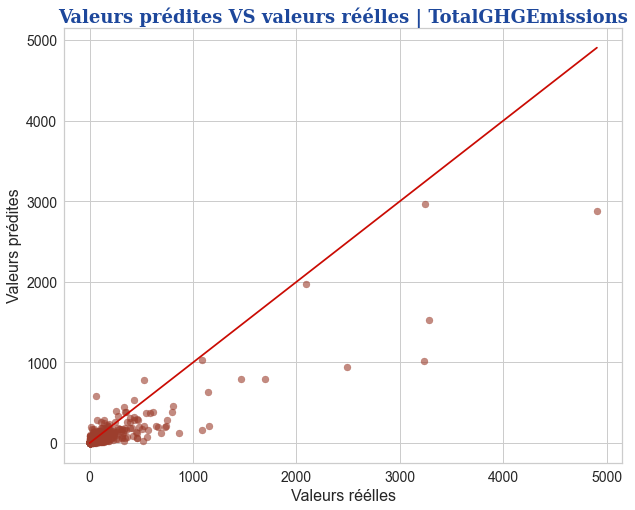

In [139]:
plot_pred_true(y_test,grid_bag.best_estimator_.predict(X_test), color="#9C3E2D", title="TotalGHGEmissions")

## B.2.10 Features importantes avec Bagging 

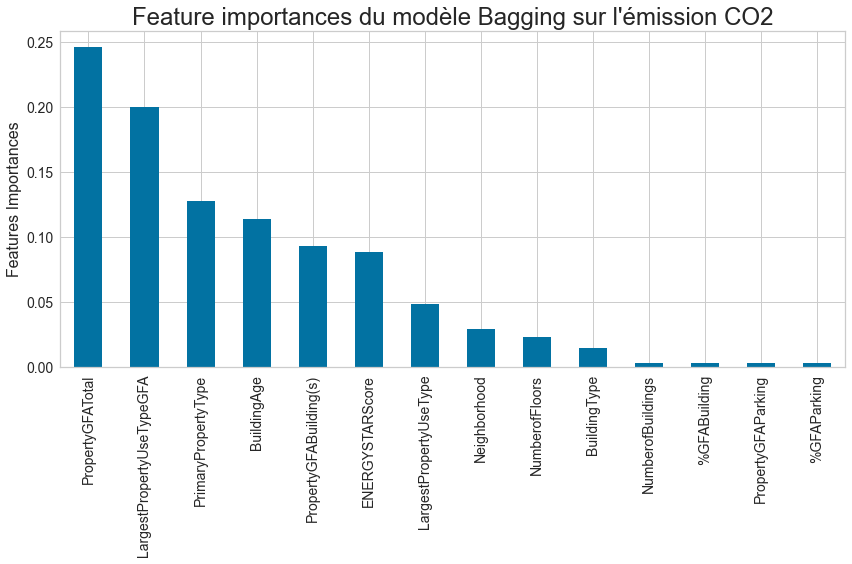

In [140]:

feature_importance = np.mean([tree.feature_importances_ for tree in\
                              grid_bag.best_estimator_.named_steps['transformedtargetregressor']\
                              .regressor_.estimators_], axis=0)
feature_names = cat_feature + num_feature


df_feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar()
ax.set_title("Feature importances du modèle Bagging sur l'émission CO2",
             fontsize = 24)
ax.set_ylabel("Features Importances", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks( fontsize = 14)
fig.tight_layout()